In [1]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multinomial
from typing import List
from scipy.stats import norm
import theano.tensor as tt
import theano
from sklearn.metrics import accuracy_score as acc
from tqdm.notebook import tqdm


#import warnings
#warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
n_states = 3
n_actions = 2

p_init = np.array([3/6., 2/6., 1/6.])
p_actions = np.array([0.8, 0.2])
p_transition_0 = np.array(
    [[0.90, 0.09, 0.01],
     [0.  , 0.90, 0.1 ],
     [0.  , 0.  , 1.  ]]
)
p_transition_1 = np.array(
    [[1.  , 0.  , 0.  ],
     [0.9 , 0.1 , 0.  ],
     [0.49, 0.5 , 0.01]]
)
p_transitions = np.array([p_transition_0, p_transition_1])
p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.  , 0.9 , 0.1 ],
        [0.  , 0.  , 1.  ]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

In [3]:
for i in range(n_actions):
    assert p_transitions[i, 0, :].sum() == 1
    assert p_transitions[i, 1, :].sum() == 1
    assert p_transitions[i, 2, :].sum() == 1

In [4]:
def deterioration_process(prev_em, mu, sigma):
    return pm.TruncatedNormal.dist(mu=prev_em, sigma=sigma, upper=prev_em).random(size=1)

def repair_process(prev_em, mu, sigma, k):
    return pm.TruncatedNormal.dist(mu=k*prev_em + mu, sigma=sigma, upper=0.).random(size=1)

def generate_emissions(state, action, prev_em, mus, sigmas, k):
    mu = mus[state]
    sigma = sigmas[state]
    if action == 0:
        return deterioration_process(prev_em, mu, sigma)
    elif action == 1:
        return repair_process(prev_em, mu, sigma, k)
    else: 
        raise("No action defined")

In [5]:
def select_action(em):
    if em > -1.5:
        return 0
    else:
        return 1

In [6]:
def pomdp_deterioration_sequence(p_init, p_actions, p_transitions, sequence_length, mus, sigmas, k):
    """
    #Generate a Markov Decision Process sequence based on p_init, p_actions and p_transitions.
    """
    initial_state = list(multinomial.rvs(1, p_init)).index(1)
    initial_em = generate_emissions(initial_state, 0, mus[initial_state], mus, sigmas, k)[0]
    #initial_action = list(multinomial.rvs(1, p_actions)).index(1)

    states = [initial_state]
    #actions = [initial_action]
    actions = [0]
    emissions = [initial_em]
    for _ in range(sequence_length - 1):
        p_tr = p_transitions[actions[-1], states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        new_em = generate_emissions(new_state, actions[-1], emissions[-1], mus, sigmas, k)[0]
        #new_action = list(multinomial.rvs(1, p_actions)).index(1)
        new_action = select_action(new_em)
        states.append(new_state)
        emissions.append(new_em)
        actions.append(new_action)
    return states, actions, emissions

In [7]:
def plot_emissions(states, emissions, actions):
    fig, axes = plt.subplots(figsize=(16, 12), nrows=3, ncols=1, sharex=True)
    axes[0].plot(states)
    axes[0].set_title("States")
    axes[1].plot(emissions)
    axes[1].set_title("Emissions")
    axes[2].plot(actions)
    axes[2].set_title("Actions")
    sns.despine();

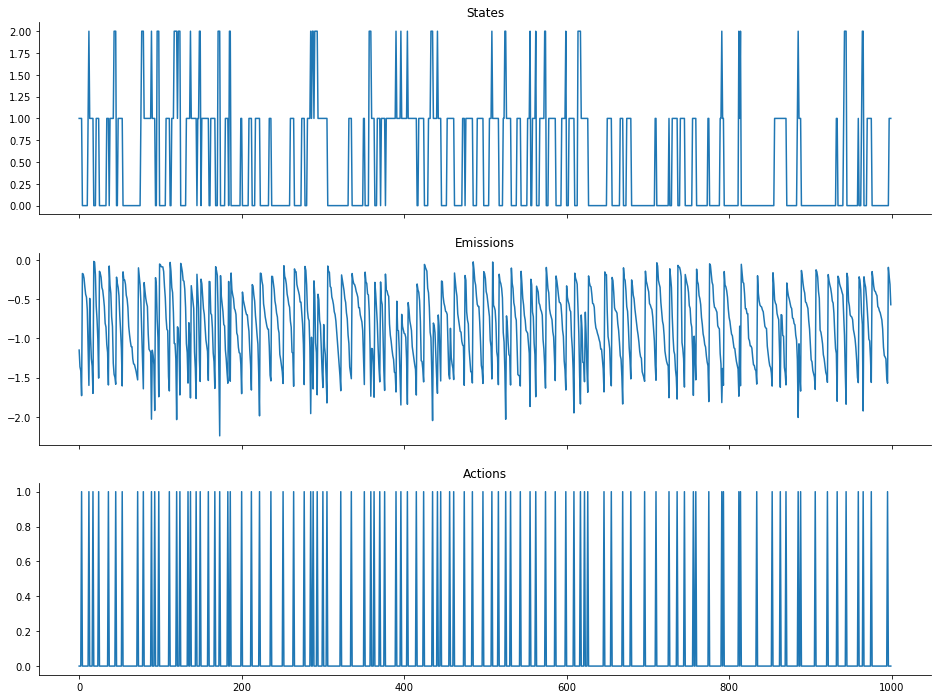

In [12]:
lenght_seq = 1000
mus = [-0.01, -0.5, -1.]
sigmas = [0.1, 0.25, 0.5]
k = 0.1

states, actions, emissions = pomdp_deterioration_sequence(p_init, p_actions, p_transitions, lenght_seq, mus, sigmas, k)
plot_emissions(states, emissions, actions)

In [13]:
class HMMStates(pm.Categorical):
    def __init__(self, p_transition, init_prob, actions, n_states, *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.p_transition = p_transition
        self.init_prob = init_prob
        self.actions = actions
        self.k = n_states
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        p_init = self.init_prob
        acts = self.actions[:-1]
        p_tr = self.p_transition[acts, x[:-1]]

        # the logp of the initial state 
        initial_state_logp = pm.Categorical.dist(p_init).logp(x[0])

        # the logp of the rest of the states.
        x_i = x[1:]
        ou_like = pm.Categorical.dist(p_tr).logp(x_i)
        transition_logp = tt.sum(ou_like)
        return initial_state_logp + transition_logp

In [14]:
with pm.Model() as model:
    #transition_mat = pm.Dirichlet(
    #    "p_transition",
    #    a=tt.ones((n_actions, n_states, n_states)), 
    #    shape=(n_actions, n_states, n_states))
    transition_mat_0 = pm.Dirichlet(
        "tr_mat_0",
        a=np.diag(np.array([5.]*n_states))+1,
        shape=(n_states, n_states))
    transition_mat_1 = pm.Dirichlet(
        "tr_mat_1",
        a=np.array([[5.,0.5, 0.5], [5.,1.,0.5], [4.,4.,1.]]),
        shape=(n_states, n_states))
    transition_mat = pm.Deterministic("p_transition", tt.stack([transition_mat_0, transition_mat_1]))

    init_probs = pm.Dirichlet('init_probs', a = tt.ones((n_states,)), shape=n_states)
    
    obs_states = HMMStates(
        "states",
        p_transition=transition_mat,
        init_prob=init_probs,
        n_states=n_states,
        actions = actions,
        observed=np.array(states).astype("float")
    )
    
    trace = pm.sample(2000, target_accept=0.9)

<ipython-input-14-167cd5db3ea9>:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [init_probs, tr_mat_1, tr_mat_0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 78 seconds.


/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


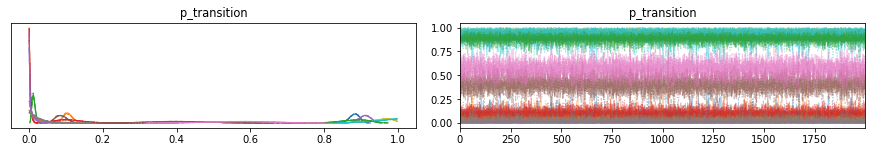

In [16]:
az.plot_trace(trace,  var_names=["p_transition"]);

In [17]:
p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.  , 0.9 , 0.1 ],
        [0.  , 0.  , 1.  ]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


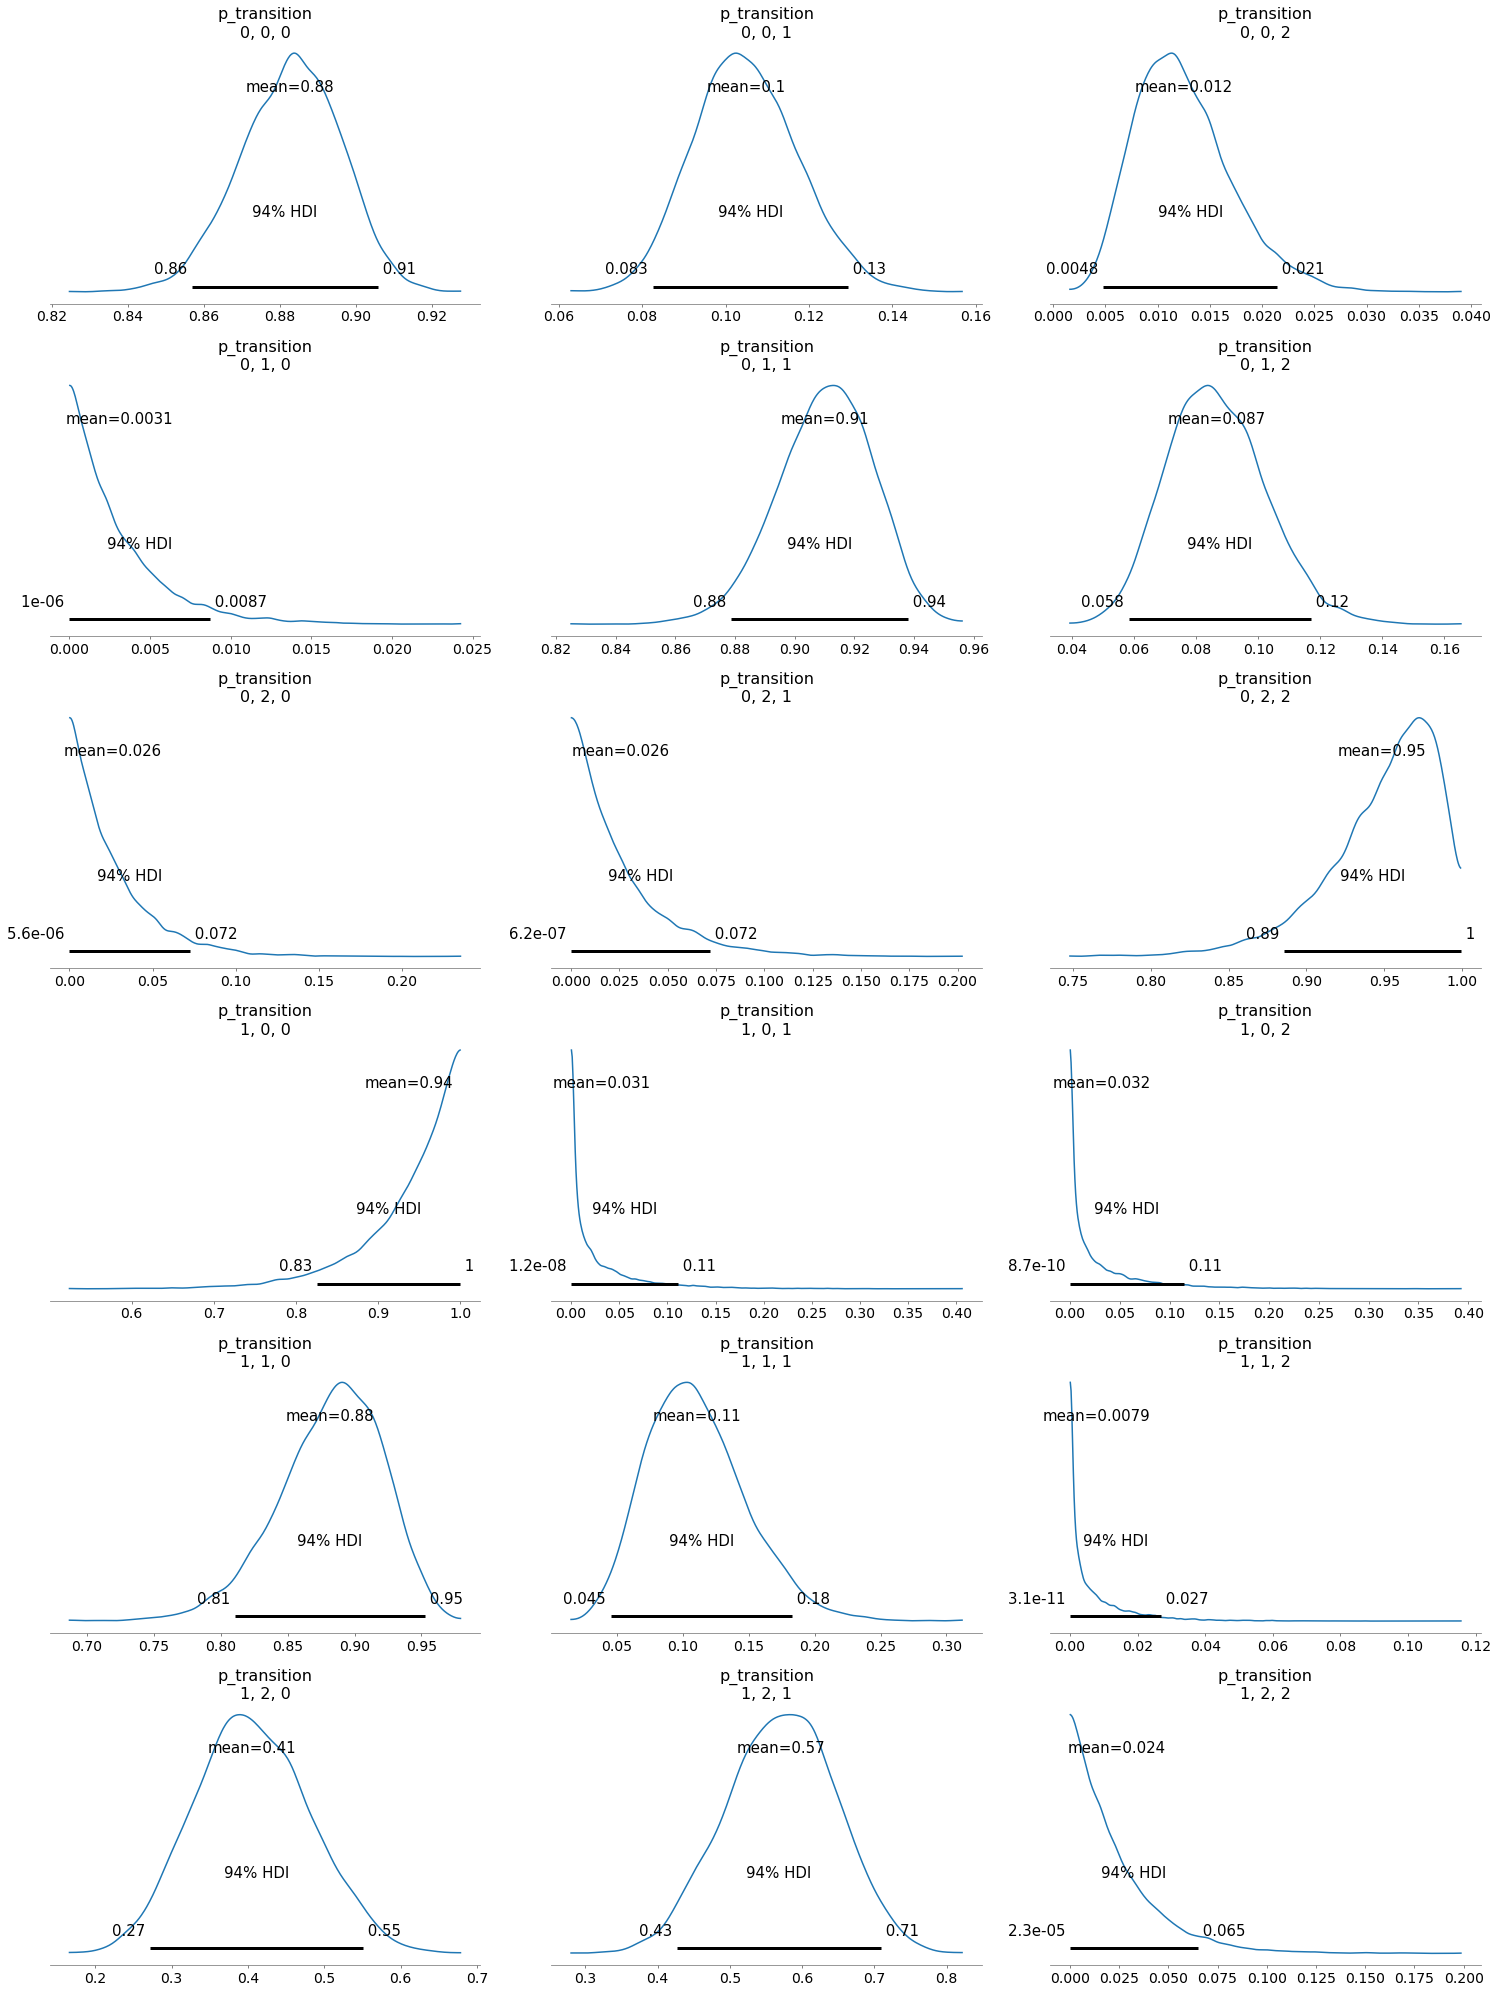

In [18]:
az.plot_posterior(trace, var_names=["p_transition"]);

In [66]:
class ObservationModel(pm.Continuous):
    def __init__(self, states, mu, sigma, k, actions, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.states = states
        self.sigma = sigma 
        self.mu = mu
        self.k = k
        self.indices_0 = [i for i, x in enumerate(actions[:-1]) if x == 0]
        self.indices_1 = [i for i, x in enumerate(actions[:-1]) if x == 1]

    def logp(self, x):
        """
        x: observations
        """
        states = self.states
        mu = self.mu[states]
        sigma = self.sigma[states]
        k = self.k

        prev_x = x[:-1]
        cur_x = x[1:]
        x_det = cur_x[self.indices_0]
        x_rep = cur_x[self.indices_1]
        prev_x_det = prev_x[self.indices_0]
        prev_x_rep = prev_x[self.indices_1]
        cur_mu = mu[1:]
        cur_sigma = sigma[1:]
        mu_det = cur_mu[self.indices_0]
        mu_rep = cur_mu[self.indices_1]
        sigma_det = cur_sigma[self.indices_0]
        sigma_rep = cur_sigma[self.indices_1]
        
        det_like = tt.sum(pm.TruncatedNormal.dist(mu=prev_x_det, sigma=sigma_det, upper=prev_x_det).logp(x_det))
        rep_like = tt.sum(pm.TruncatedNormal.dist(mu=k*prev_x_rep + mu_rep, sigma=sigma_rep, upper=0.).logp(x_rep))
        boundary_like = pm.TruncatedNormal.dist(mu=mu[0], sigma=sigma[0], upper=0.).logp(x[0])
        return det_like + rep_like + boundary_like

In [34]:
with pm.Model() as model:
    transition_mat_0 = pm.Dirichlet(
        "tr_mat_0",
        a=np.diag(np.array([5.]*n_states))+1,
        shape=(n_states, n_states))
    transition_mat_1 = pm.Dirichlet(
        "tr_mat_1",
        a=np.array([[5.,0.5, 0.5], [5.,1.,0.5], [4.,4.,1.]]),
        shape=(n_states, n_states))
    transition_mat = pm.Deterministic("p_transition", tt.stack([transition_mat_0, transition_mat_1]))
    
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones((n_states,)), shape=n_states)

    # HMM state
    hmm_states = HMMStates(
        "hmm_states",
        p_transition=transition_mat,
        init_prob=init_probs,
        n_states=n_states,
        actions=actions,
        shape=(len(emissions),)
    )

    # Prior for mu, sigma and k
    μ = pm.TruncatedNormal("mu", mu=[-0.01, -0.5, -1.], sigma=0.2, upper=0., shape=(n_states,)) # different priors for the 3 Normal dist
    #σ = pm.Exponential("sigma", lam=[10.,1.,1/10.], shape=(n_states,))
    σ = pm.TruncatedNormal("sigma", mu=[0.1, 0.25, 0.5], sigma=0.1, lower=0., shape=(n_states,))
    k_p = pm.Beta("k", alpha=2., beta=5.) 

    # Observed emission likelihood
    obs = ObservationModel(
        "emission",
        states=hmm_states,
        mu=μ,
        sigma=σ,
        k=k_p,
        actions=actions,
        observed=emissions
    )
    
    nuts_step = pm.NUTS([model.k, model.sigma, model.mu, model.p_transition, model.init_probs], target_accept=0.95) 
    trace = pm.sample(2000, tune=1500, step=[nuts_step])

<ipython-input-34-f2985945f28e>:60: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=1500, step=[nuts_step])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [init_probs, tr_mat_0, tr_mat_1, mu, sigma, k]
>CategoricalGibbsMetropolis: [hmm_states]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 2376 seconds.
/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [35]:
az.summary(trace, var_names=["p_transition", "mu", "sigma", "k"])

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_transition[0,0,0]  0.864  0.019   0.829    0.899      0.001    0.001   
p_transition[0,0,1]  0.111  0.025   0.063    0.158      0.002    0.001   
p_transition[0,0,2]  0.024  0.019   0.000    0.058      0.001    0.001   
p_transition[0,1,0]  0.030  0.024   0.000    0.073      0.002    0.001   
p_transition[0,1,1]  0.842  0.072   0.713    0.973      0.008    0.006   
p_transition[0,1,2]  0.128  0.069   0.002    0.242      0.007    0.005   
p_transition[0,2,0]  0.062  0.059   0.000    0.164      0.004    0.002   
p_transition[0,2,1]  0.121  0.100   0.000    0.304      0.006    0.004   
p_transition[0,2,2]  0.817  0.113   0.609    0.988      0.008    0.006   
p_transition[1,0,0]  0.924  0.071   0.794    1.000      0.001    0.001   
p_transition[1,0,1]  0.039  0.053   0.000    0.137      0.001    0.001   
p_transition[1,0,2]  0.037  0.050   0.000    0.130      0.001    0.001   
p_transition[1,1,0]  0.894  0.071   0.766    1.000      0.005    0.004   
p_transition[1,1,1]  0.084  0.069   0.000    0.214      0.005    0.004   
p_transition[1,1,2]  0.022  0.031   0.000    0.076      0.001    0.001   
p_transition[1,2,0]  0.466  0.123   0.237    0.691      0.008    0.005   
p_transition[1,2,1]  0.479  0.128   0.253    0.731      0.008    0.006   
p_transition[1,2,2]  0.055  0.054   0.000    0.157      0.002    0.002   
mu[0]               -0.055  0.037  -0.119   -0.000      0.001    0.001   
mu[1]               -0.650  0.081  -0.799   -0.498      0.003    0.002   
mu[2]               -0.945  0.192  -1.312   -0.592      0.004    0.003   
sigma[0]             0.101  0.004   0.093    0.109      0.000    0.000   
sigma[1]             0.262  0.020   0.225    0.300      0.001    0.001   
sigma[2]             0.416  0.049   0.333    0.509      0.004    0.003   
k                    0.063  0.023   0.020    0.102      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_transition[0,0,0]     445.0    1084.0   1.01  
p_transition[0,0,1]     228.0     412.0   1.02  
p_transition[0,0,2]     208.0     425.0   1.01  
p_transition[0,1,0]     180.0     511.0   1.02  
p_transition[0,1,1]      79.0     157.0   1.05  
p_transition[0,1,2]      89.0     203.0   1.04  
p_transition[0,2,0]     313.0     491.0   1.01  
p_transition[0,2,1]     275.0     596.0   1.02  
p_transition[0,2,2]     205.0     534.0   1.03  
p_transition[1,0,0]    3242.0    4570.0   1.00  
p_transition[1,0,1]    2652.0    2637.0   1.00  
p_transition[1,0,2]    3400.0    3105.0   1.00  
p_transition[1,1,0]     193.0     406.0   1.03  
p_transition[1,1,1]     200.0     341.0   1.03  
p_transition[1,1,2]     634.0    1002.0   1.00  
p_transition[1,2,0]     257.0    1123.0   1.01  
p_transition[1,2,1]     242.0     594.0   1.01  
p_transition[1,2,2]     637.0     844.0   1.01  
mu[0]                  2338.0    2142.0   1.00  
mu[1]                   909.0    1649.0   1.00  
mu[2]                  2215.0    2803.0   1.00  
sigma[0]                449.0    1190.0   1.00  
sigma[1]                192.0     464.0   1.02  
sigma[2]                189.0     487.0   1.02  
k                      2520.0    2738.0   1.00

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


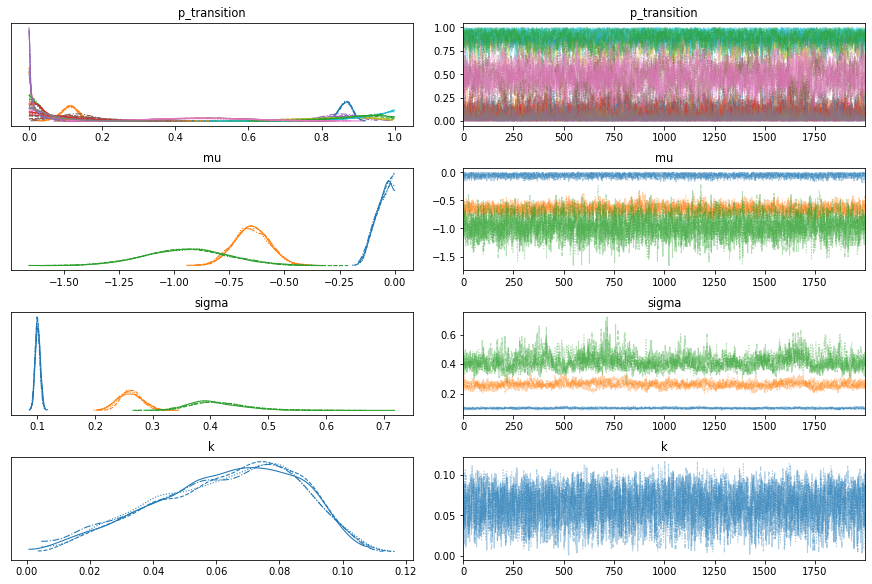

In [36]:
az.plot_trace(trace, var_names=["p_transition", "mu", "sigma", "k"]);

In [37]:
p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.  , 0.9 , 0.1 ],
        [0.  , 0.  , 1.  ]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


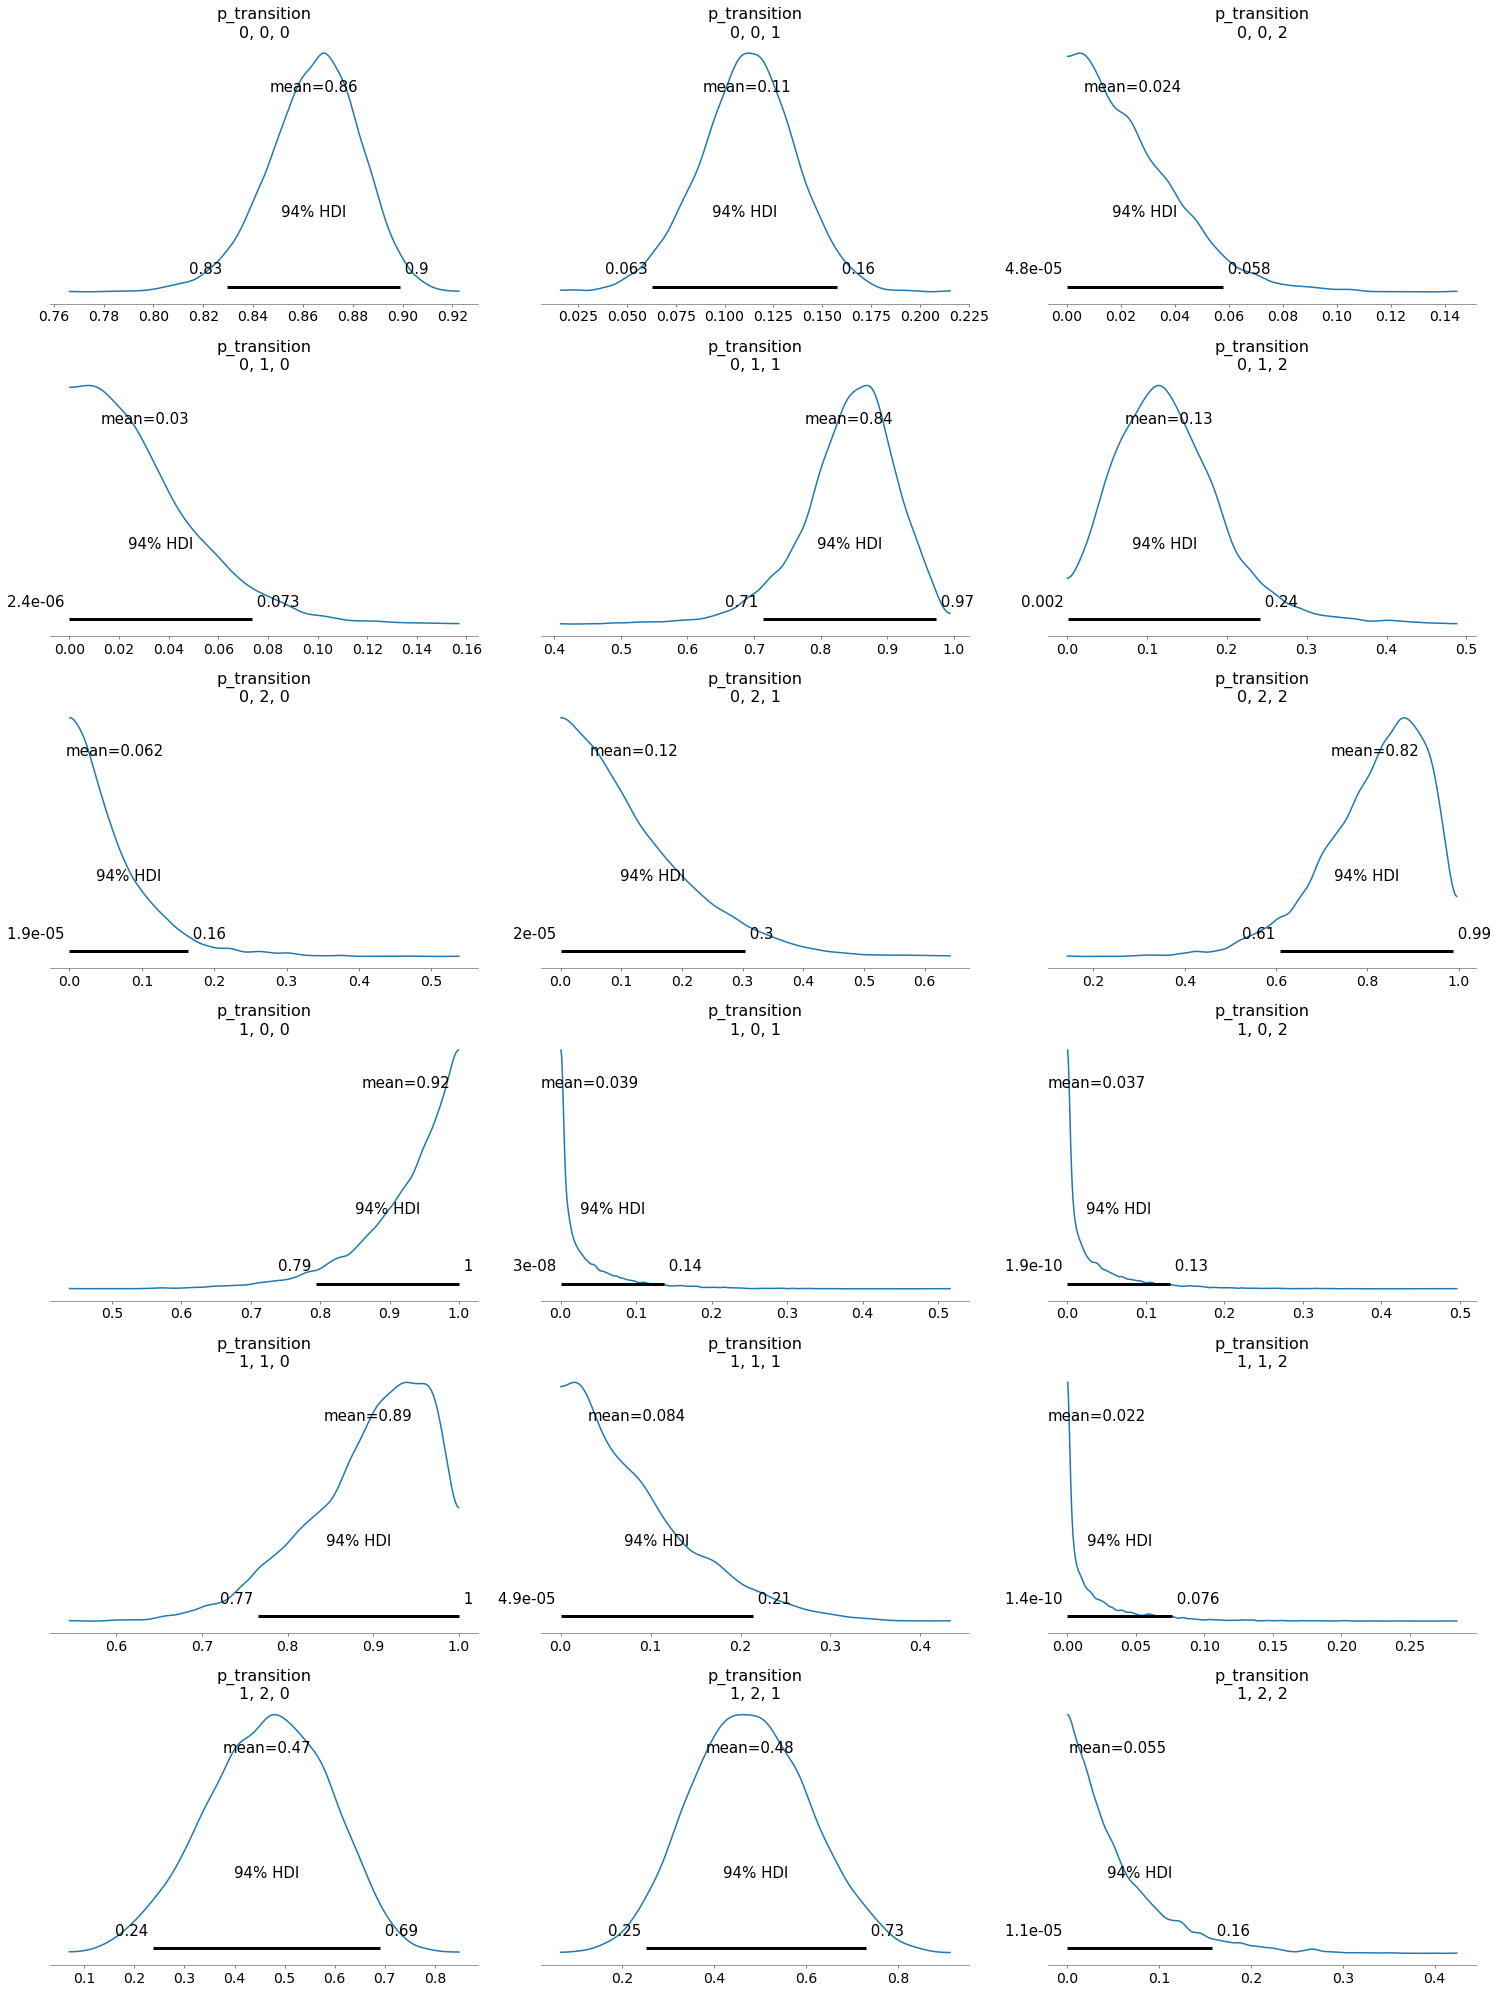

In [38]:
az.plot_posterior(trace, var_names=["p_transition"]);

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


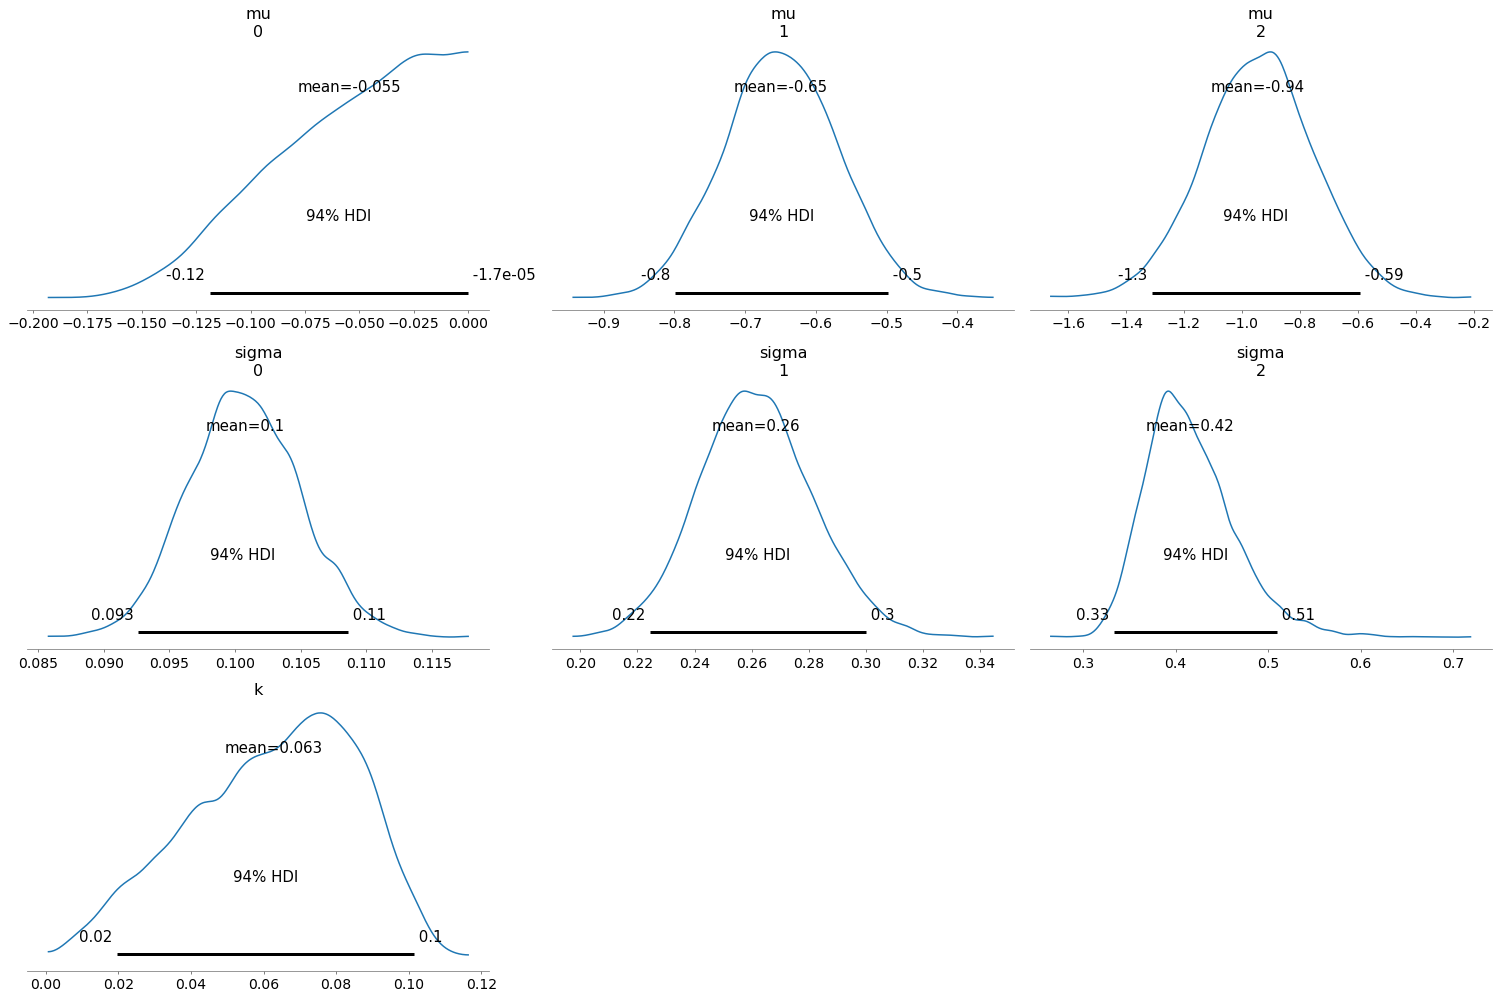

In [39]:
az.plot_posterior(trace, var_names=["mu", "sigma", "k"]);

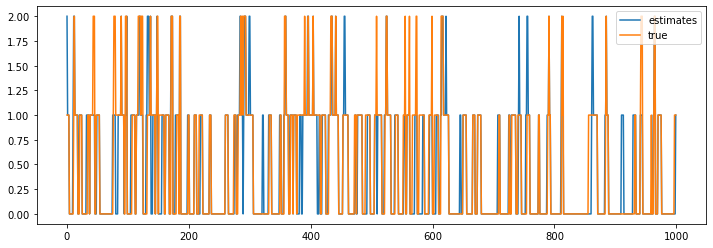

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.round(trace["hmm_states"].mean(axis=0)), label="estimates")
ax.plot(np.array(states), label="true")
plt.legend();

In [27]:
acc(np.array(states), np.round(trace["hmm_states"].mean(axis=0)))

0.851

In [63]:
def generate_multiple_pomdp_det_seq(lenght_seq, number_seq, p_transition, p_init, p_actions, k, mus, sigmas, plot=True): 
    states_all_seq = np.full((number_seq, lenght_seq), np.nan)
    actions_all_seq = np.full((number_seq, lenght_seq), np.nan)
    emissions_all_seq = np.full((number_seq, lenght_seq), np.nan)
    for i in tqdm(range(number_seq)):
        states, actions, emissions = pomdp_deterioration_sequence(p_init, p_actions, p_transitions, lenght_seq, mus, sigmas, k)
        states_all_seq[i, :] = states
        actions_all_seq[i, :] = actions
        emissions_all_seq[i, :] = emissions
        if plot:
            plot_emissions(states_all_seq[i, :], emissions_all_seq[i, :], actions_all_seq[i, :])
    states_all_seq = states_all_seq.astype(int)
    actions_all_seq = actions_all_seq.astype(int)
    return states_all_seq, emissions_all_seq, actions_all_seq

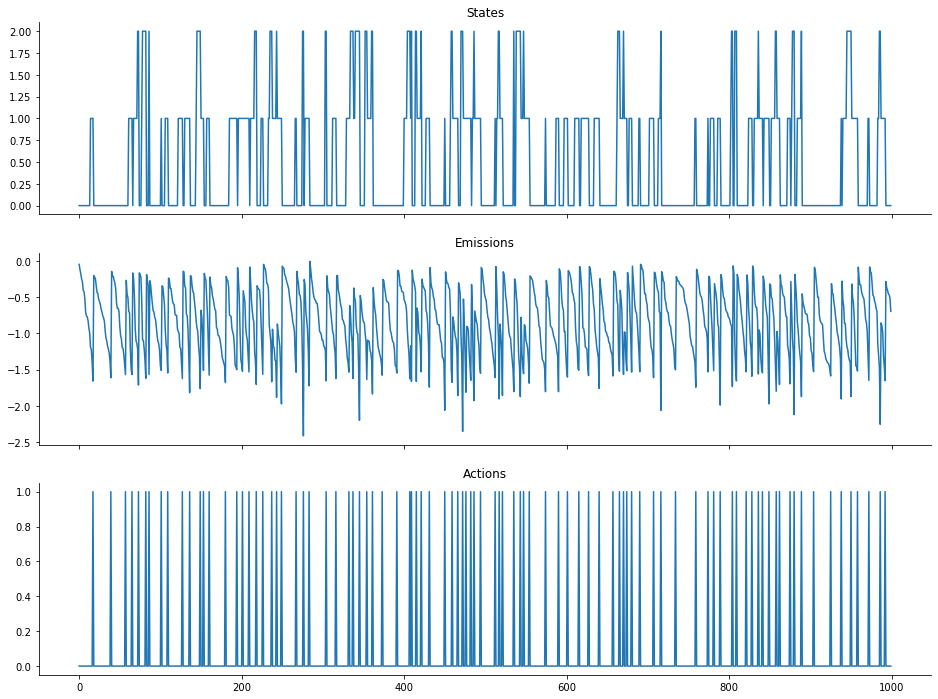

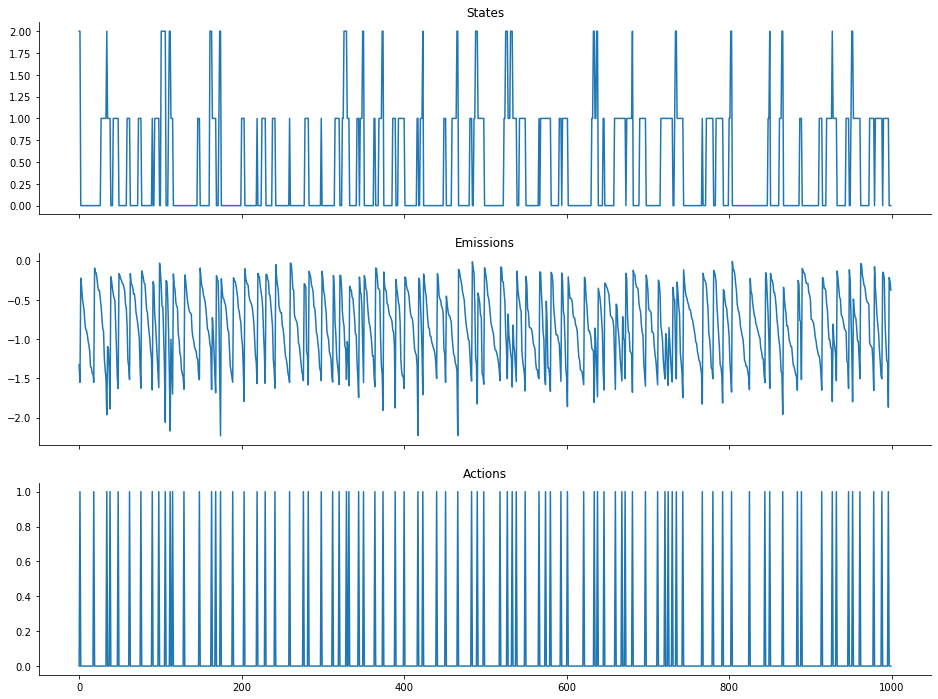

In [44]:
lenght_seq = 1000
number_seq = 2
mus = [-0.01, -0.5, -1.]
sigmas = [0.1, 0.25, 0.5]
k = 0.1

states_all_seq, emissions_all_seq, actions_all_seq = generate_multiple_pomdp_det_seq(lenght_seq, number_seq, p_transitions, 
                                                                                     p_init, p_actions, k, mus, sigmas)

In [45]:
with pm.Model() as model:
    transition_mat_0 = pm.Dirichlet(
        "tr_mat_0",
        a=np.diag(np.array([5.]*n_states))+1,
        shape=(n_states, n_states))
    transition_mat_1 = pm.Dirichlet(
        "tr_mat_1",
        a=np.array([[5.,0.5, 0.5], [5.,1.,0.5], [4.,4.,1.]]),
        shape=(n_states, n_states))
    transition_mat = pm.Deterministic("p_transition", tt.stack([transition_mat_0, transition_mat_1]))
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones((n_states,)), shape=n_states)
    
    for i in range(number_seq):
        obs_states = HMMStates(
            "states_" + str(i),
            p_transition=transition_mat,
            init_prob=init_probs,
            actions=actions_all_seq[i, :],
            n_states=n_states,
            observed=np.array(states_all_seq[i, :]).astype("float")
        )
    
    trace = pm.sample(2000, tune=1000, target_accept=0.9)

<ipython-input-45-8528f1ecb7e5>:24: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=1000, target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [init_probs, tr_mat_1, tr_mat_0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 132 seconds.


/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


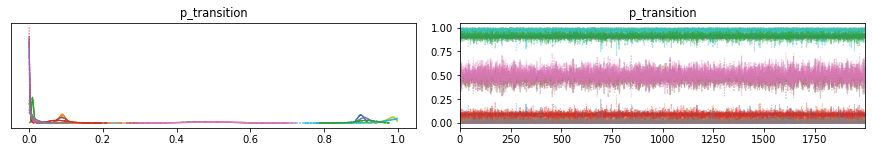

In [46]:
az.plot_trace(trace,  var_names=["p_transition"]);

In [47]:
p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.  , 0.9 , 0.1 ],
        [0.  , 0.  , 1.  ]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


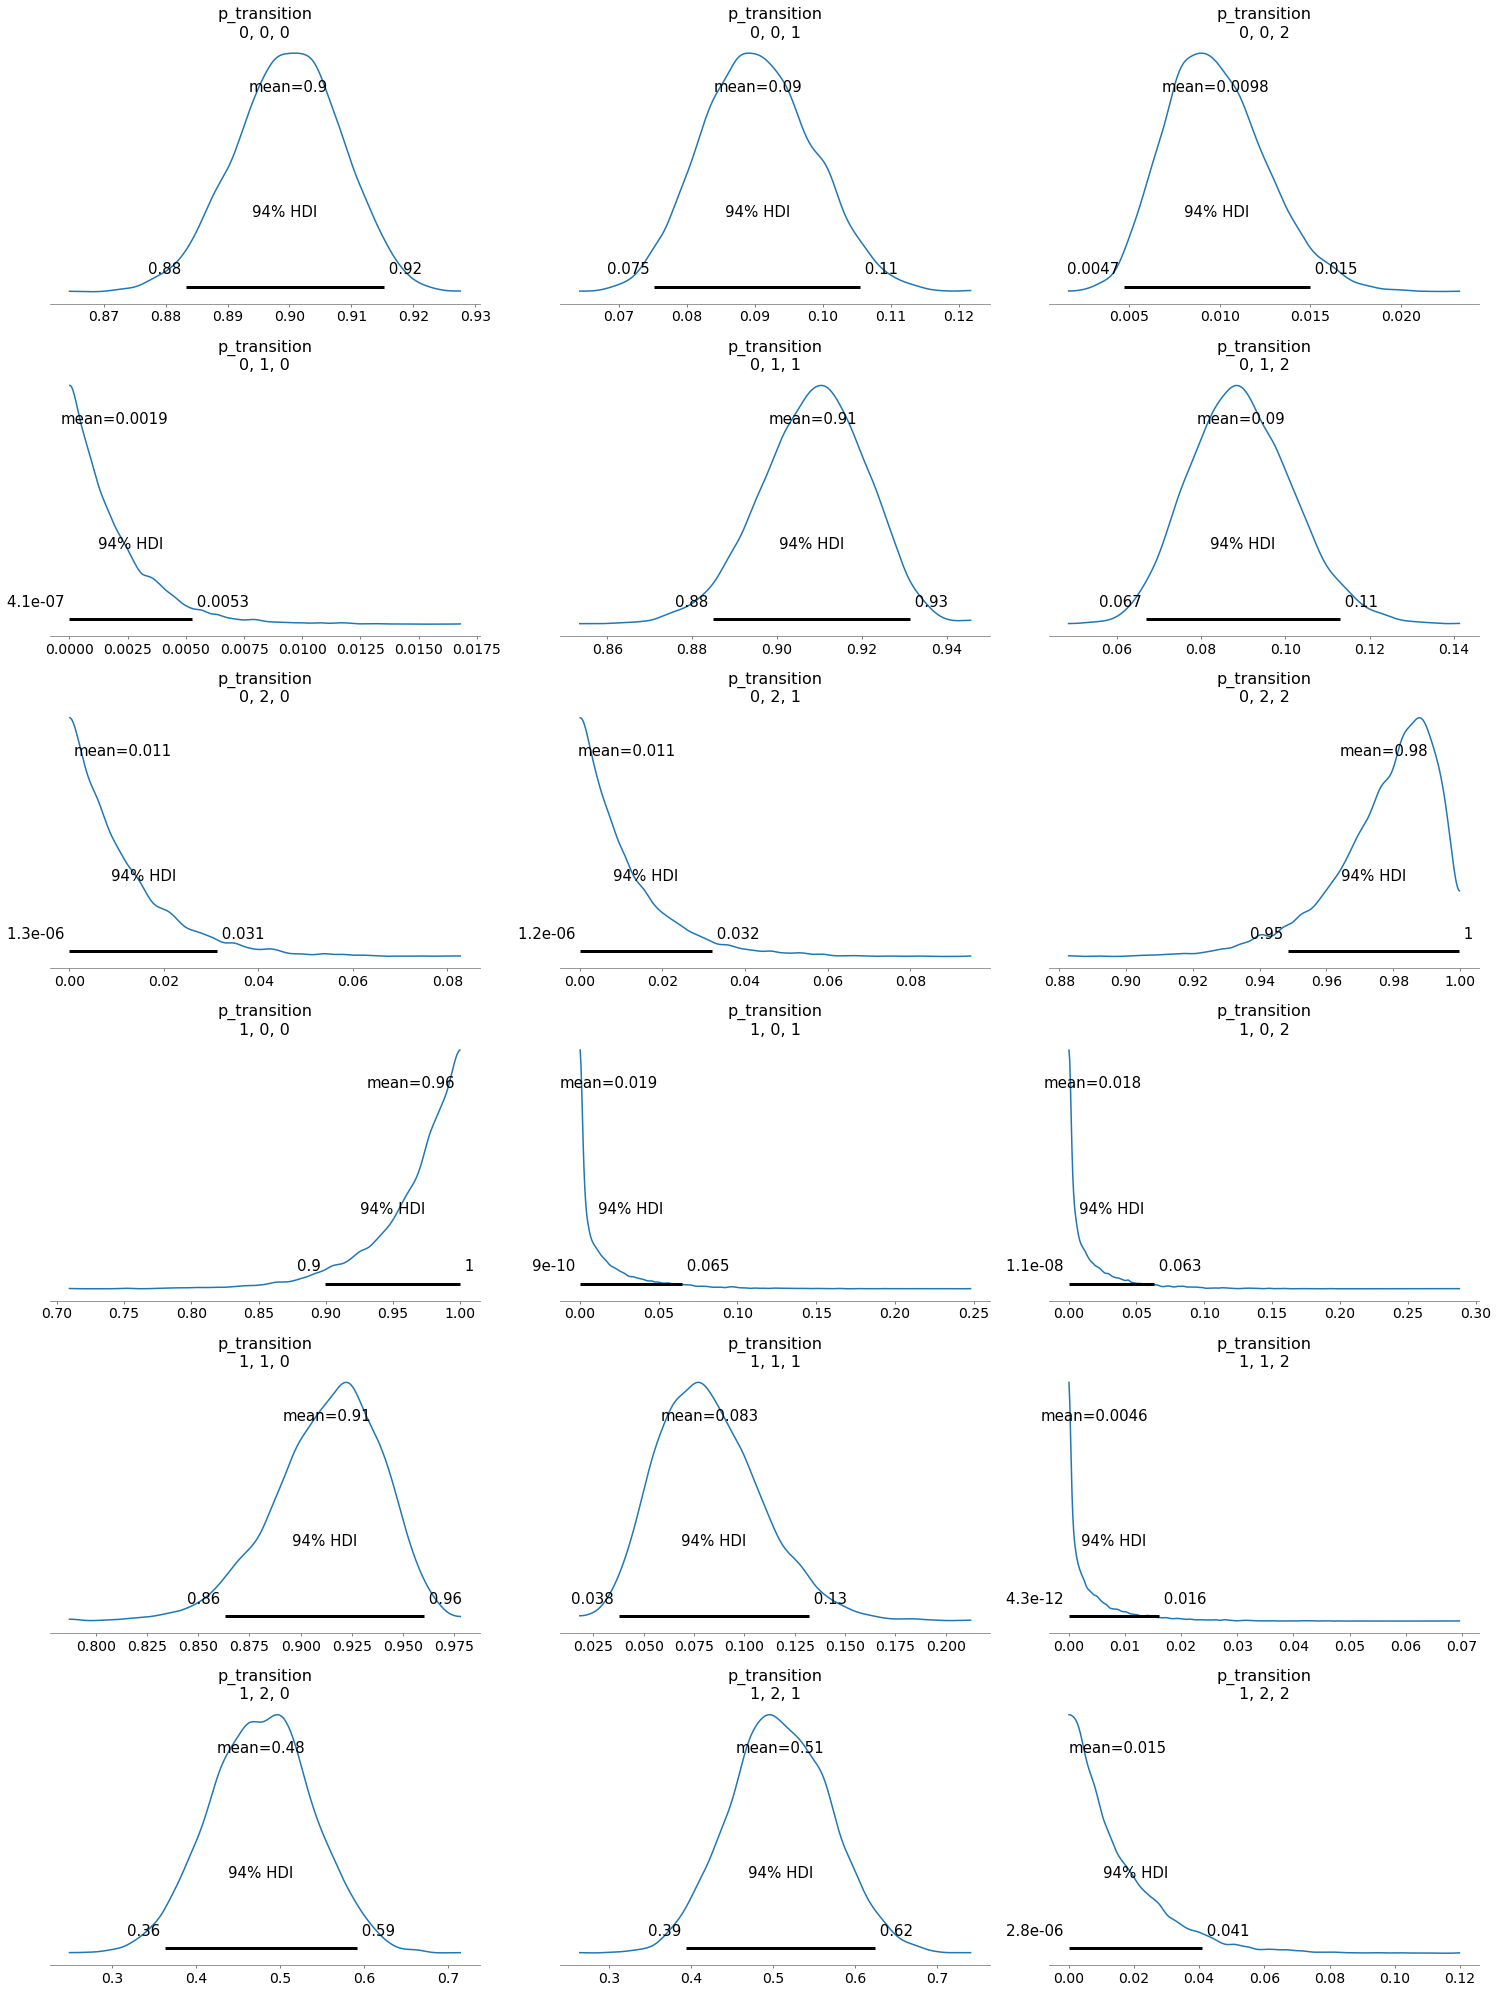

In [48]:
az.plot_posterior(trace,  var_names=["p_transition"]);

In [49]:
with pm.Model() as model:
    transition_mat_0 = pm.Dirichlet(
        "tr_mat_0",
        a=np.diag(np.array([5.]*n_states))+1,
        shape=(n_states, n_states))
    transition_mat_1 = pm.Dirichlet(
        "tr_mat_1",
        a=np.array([[5.,0.5, 0.5], [5.,1.,0.5], [4.,4.,1.]]),
        shape=(n_states, n_states))
    transition_mat = pm.Deterministic("p_transition", tt.stack([transition_mat_0, transition_mat_1]))
    
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones((n_states,)), shape=n_states)


    # Prior for mu, sigma and k
    μ = pm.TruncatedNormal("mu", mu=[-0.01, -0.5, -1.], sigma=0.1, upper=0., shape=(n_states,)) # different priors for the 3 Normal dist
    σ = pm.TruncatedNormal("sigma", mu=[0.1, 0.25, 0.5], sigma=0.1, lower=0., shape=(n_states,))
    k_p = pm.Beta("k", alpha=2., beta=5.) 
    
    for i in range(number_seq):
        # HMM state
        hmm_states_i = HMMStates(
            "hmm_states_" + str(i),
            p_transition=transition_mat,
            init_prob=init_probs,
            actions=actions_all_seq[i, :],
            n_states=n_states,
            shape=(lenght_seq,)
        )


        # Observed emission likelihood
        obs_i = ObservationModel(
            "emission_" + str(i),
            states=hmm_states_i,
            mu=μ,
            sigma=σ,
            k=k_p,
            actions=actions_all_seq[i, :],
            observed=np.array(emissions_all_seq[i, :]).astype("float")
        )
        
    nuts_step = pm.NUTS([model.k, model.sigma, model.mu, model.p_transition, model.init_probs], target_accept=0.95) 
    trace = pm.sample(2000, tune=1500, step=[nuts_step])

<ipython-input-49-0bff67e70c51>:47: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=1500, step=[nuts_step])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [init_probs, tr_mat_0, tr_mat_1, mu, sigma, k]
>CategoricalGibbsMetropolis: [hmm_states_1, hmm_states_0]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 6204 seconds.
/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [51]:
az.summary(trace,  var_names=["p_transition", "mu", "sigma", "k"])

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_transition[0,0,0]  0.896  0.011   0.874    0.916      0.001    0.001   
p_transition[0,0,1]  0.067  0.014   0.042    0.096      0.001    0.001   
p_transition[0,0,2]  0.037  0.012   0.016    0.061      0.002    0.001   
p_transition[0,1,0]  0.014  0.012   0.000    0.036      0.001    0.001   
p_transition[0,1,1]  0.933  0.041   0.859    0.997      0.006    0.005   
p_transition[0,1,2]  0.054  0.039   0.000    0.124      0.006    0.005   
p_transition[0,2,0]  0.042  0.036   0.000    0.109      0.002    0.002   
p_transition[0,2,1]  0.086  0.073   0.000    0.219      0.006    0.004   
p_transition[0,2,2]  0.872  0.079   0.730    0.992      0.006    0.004   
p_transition[1,0,0]  0.954  0.042   0.878    1.000      0.001    0.001   
p_transition[1,0,1]  0.027  0.035   0.000    0.092      0.001    0.001   
p_transition[1,0,2]  0.019  0.025   0.000    0.065      0.000    0.000   
p_transition[1,1,0]  0.875  0.061   0.774    0.991      0.008    0.005   
p_transition[1,1,1]  0.116  0.062   0.001    0.214      0.008    0.006   
p_transition[1,1,2]  0.009  0.013   0.000    0.033      0.001    0.000   
p_transition[1,2,0]  0.555  0.094   0.375    0.726      0.012    0.009   
p_transition[1,2,1]  0.420  0.093   0.256    0.602      0.011    0.008   
p_transition[1,2,2]  0.026  0.026   0.000    0.071      0.001    0.001   
mu[0]               -0.027  0.022  -0.070   -0.000      0.001    0.000   
mu[1]               -0.587  0.049  -0.682   -0.495      0.002    0.001   
mu[2]               -0.994  0.099  -1.173   -0.801      0.001    0.001   
sigma[0]             0.097  0.003   0.092    0.102      0.000    0.000   
sigma[1]             0.243  0.016   0.214    0.275      0.003    0.002   
sigma[2]             0.462  0.041   0.387    0.538      0.005    0.004   
k                    0.092  0.015   0.062    0.114      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_transition[0,0,0]     116.0     852.0   1.03  
p_transition[0,0,1]      97.0     205.0   1.03  
p_transition[0,0,2]      45.0     225.0   1.06  
p_transition[0,1,0]     185.0     347.0   1.03  
p_transition[0,1,1]      44.0     151.0   1.05  
p_transition[0,1,2]      39.0     191.0   1.06  
p_transition[0,2,0]     243.0     664.0   1.01  
p_transition[0,2,1]     157.0     512.0   1.03  
p_transition[0,2,2]     165.0     559.0   1.02  
p_transition[1,0,0]    1913.0    3539.0   1.00  
p_transition[1,0,1]    1662.0    3179.0   1.00  
p_transition[1,0,2]    2199.0    3087.0   1.00  
p_transition[1,1,0]      64.0     354.0   1.04  
p_transition[1,1,1]      60.0     322.0   1.04  
p_transition[1,1,2]     634.0     910.0   1.00  
p_transition[1,2,0]      59.0     351.0   1.05  
p_transition[1,2,1]      72.0     521.0   1.04  
p_transition[1,2,2]     957.0    2505.0   1.01  
mu[0]                  2074.0    2331.0   1.00  
mu[1]                  1026.0    3329.0   1.01  
mu[2]                  6784.0    5719.0   1.00  
sigma[0]                 89.0     554.0   1.03  
sigma[1]                 26.0     116.0   1.12  
sigma[2]                 61.0     264.0   1.05  
k                      1425.0    2163.0   1.00

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


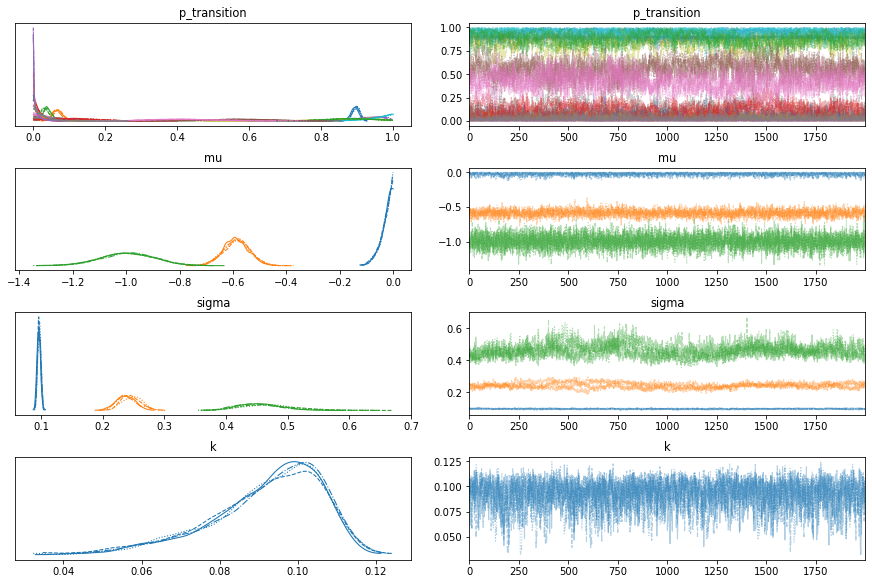

In [52]:
az.plot_trace(trace,  var_names=["p_transition", "mu", "sigma", "k"]);

In [53]:
p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.  , 0.9 , 0.1 ],
        [0.  , 0.  , 1.  ]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


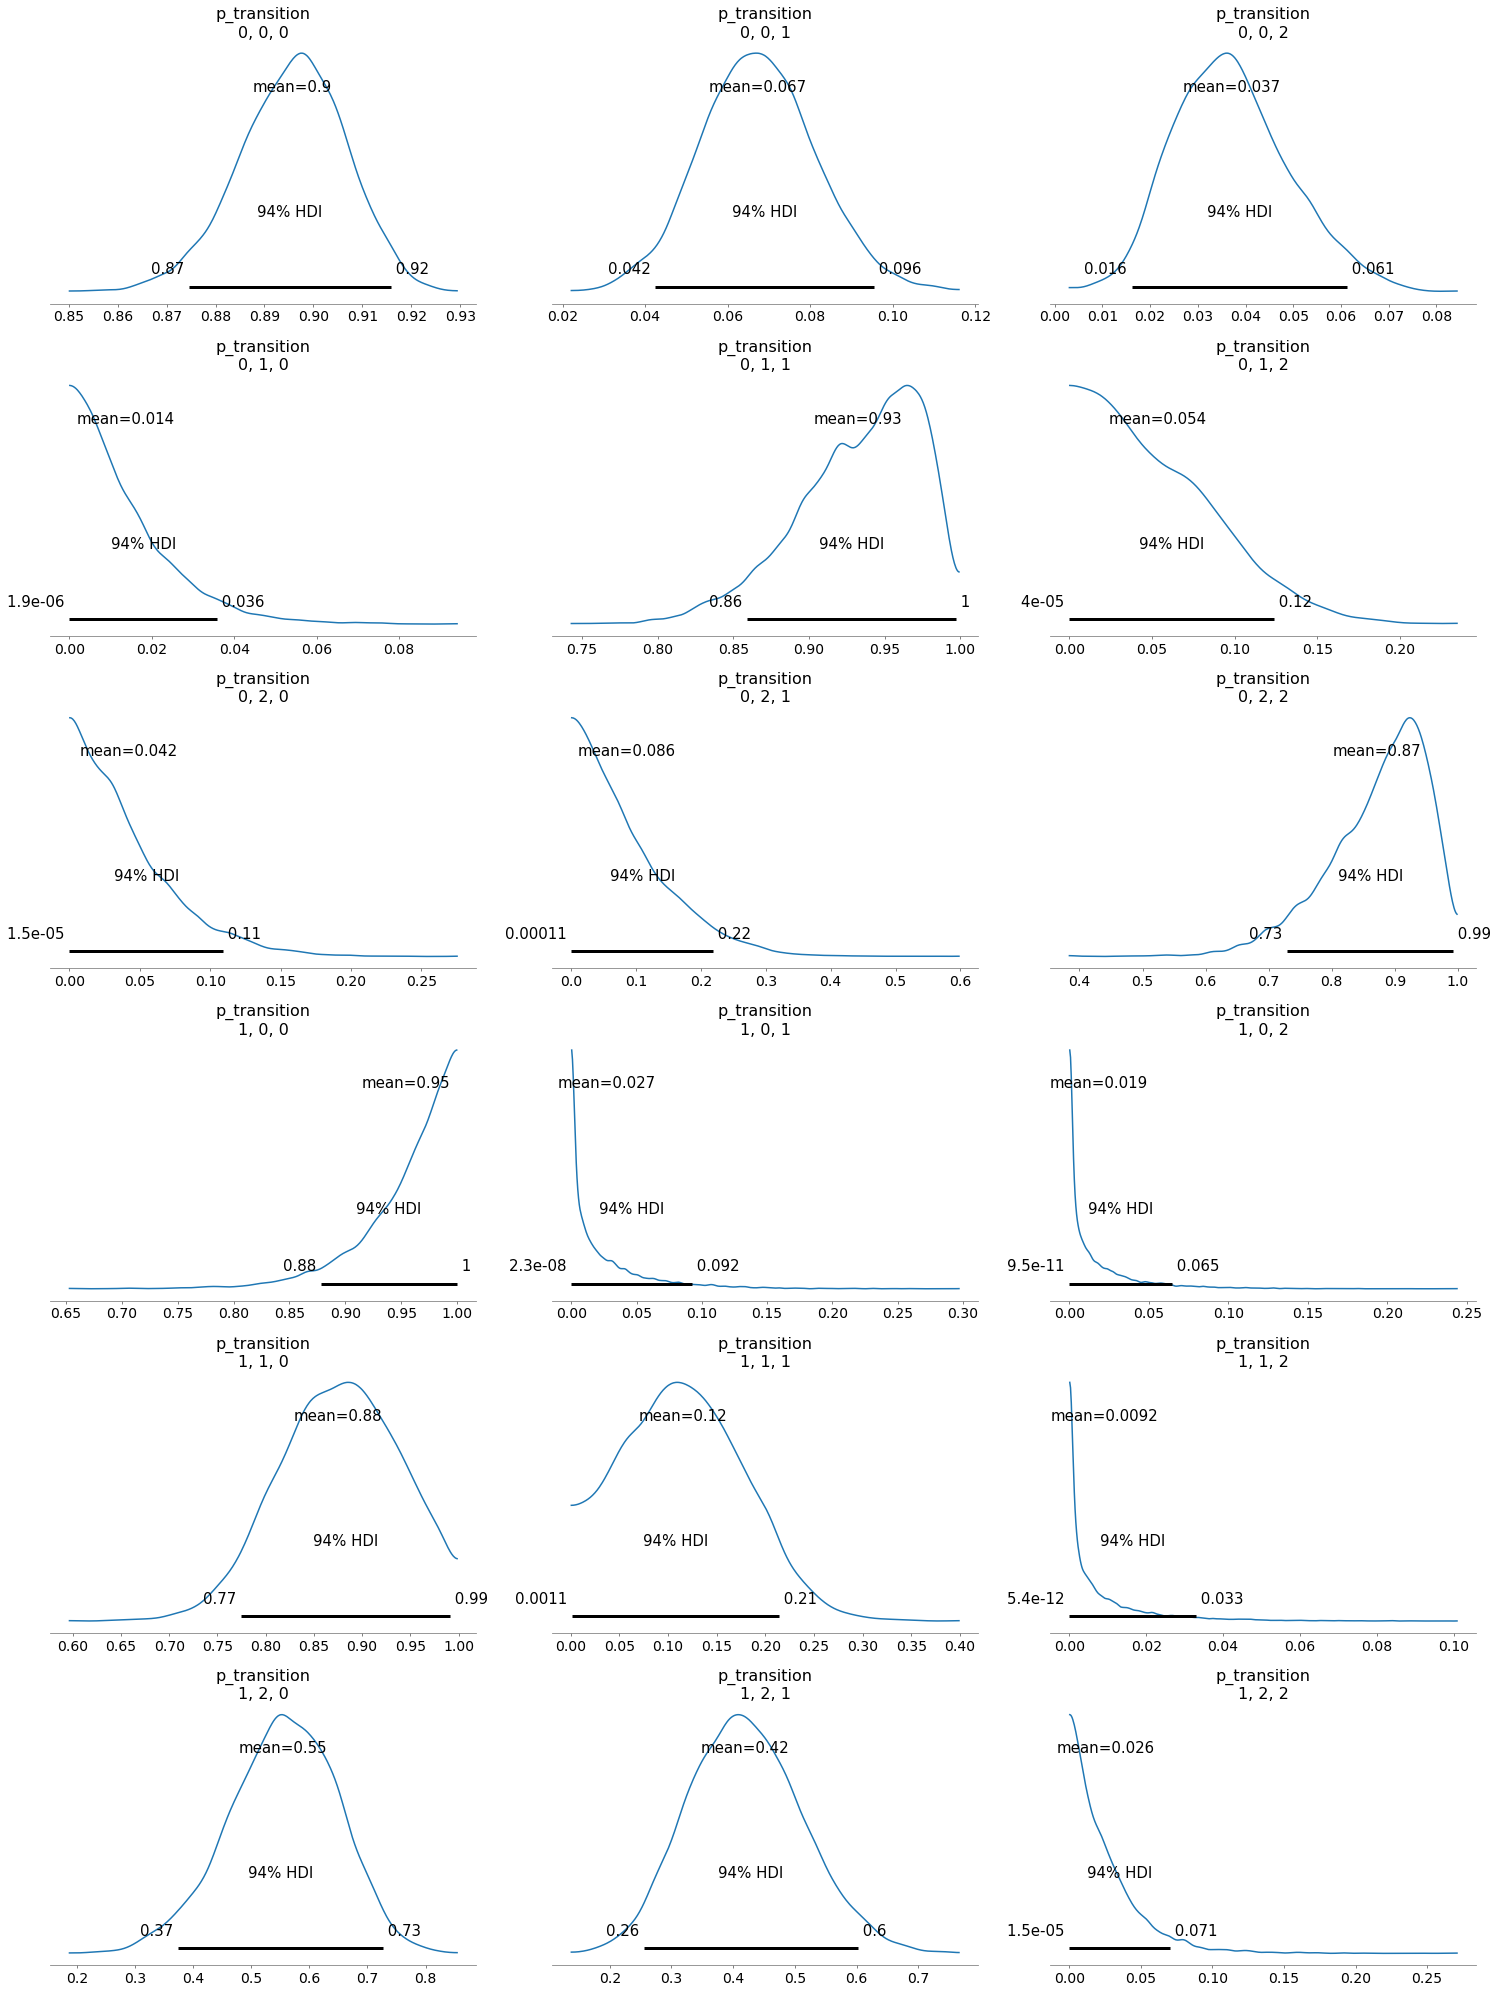

In [54]:
az.plot_posterior(trace,  var_names=["p_transition"]);

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


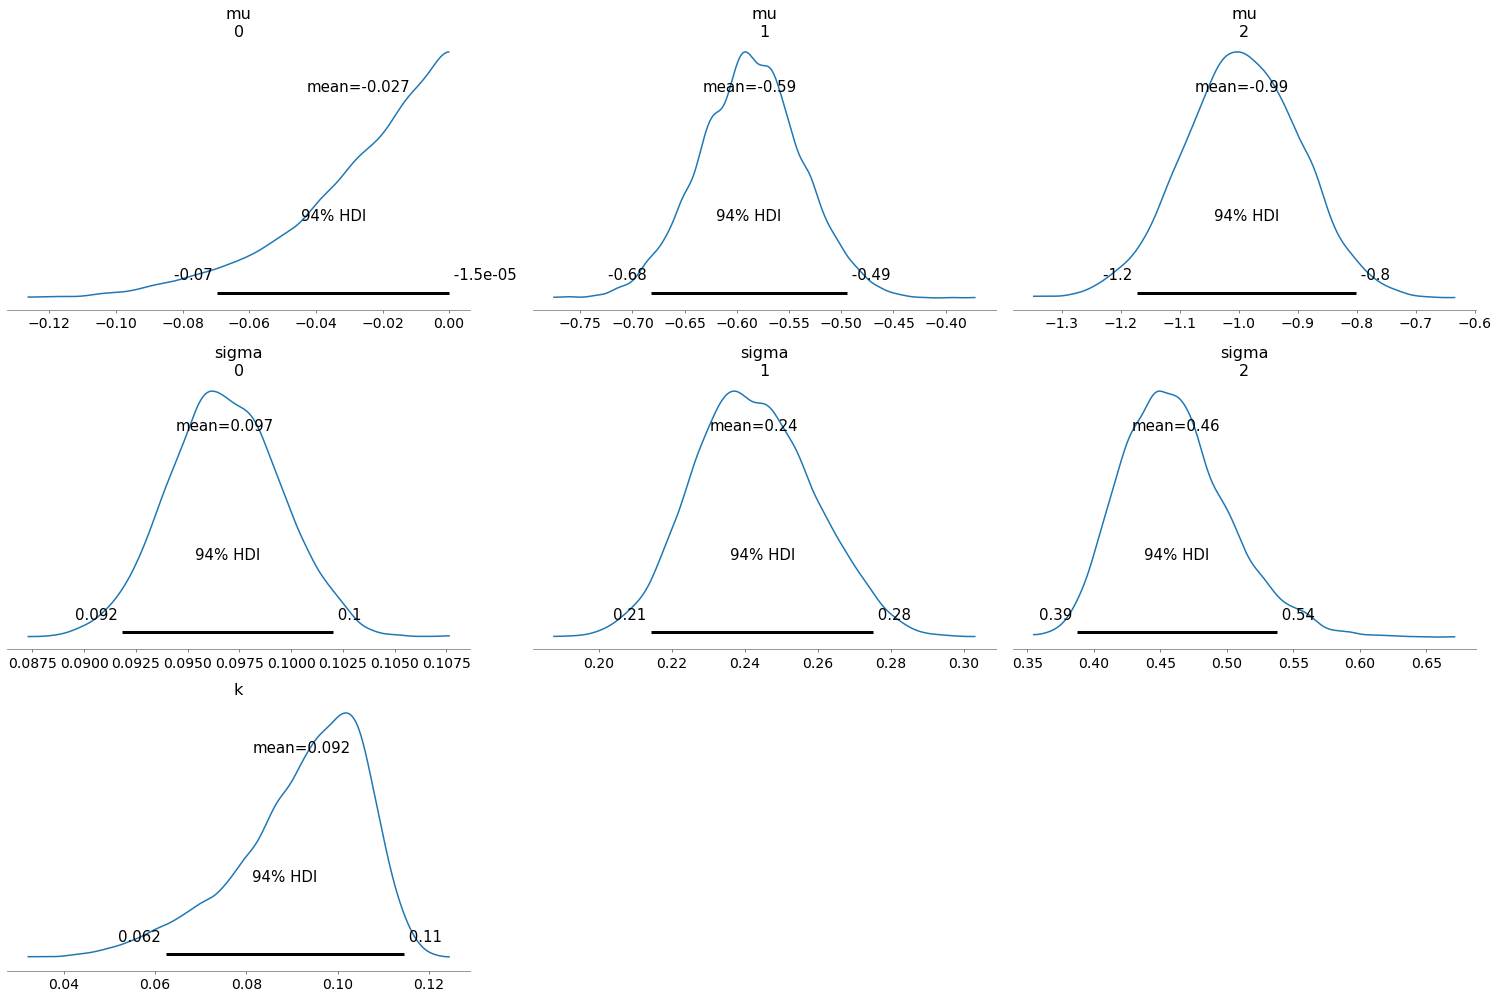

In [55]:
az.plot_posterior(trace,  var_names=["mu", "sigma", "k"]);

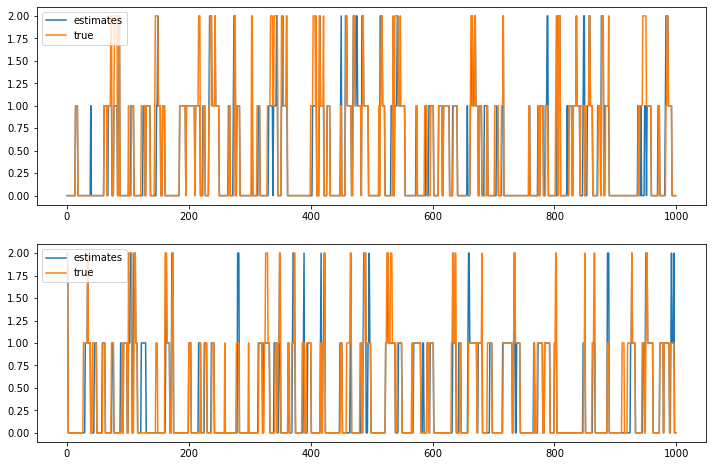

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(12, 4*number_seq))
for i in range(number_seq):
    ax[i].plot(np.round(trace["hmm_states_"+str(i)].mean(axis=0)), label="estimates")
    ax[i].plot(np.array(states_all_seq[i, :]), label="true")
    ax[i].legend()

In [57]:
for i in range(number_seq):
    print(acc(np.array(states_all_seq[i, :]), np.round(trace["hmm_states_"+str(i)].mean(axis=0))))

0.866
0.864


In [65]:
lenght_seq = 50
number_seq = 20
mus = [-0.01, -0.5, -1.]
sigmas = [0.1, 0.25, 0.5]
k = 0.1

states_all_seq, emissions_all_seq, actions_all_seq = generate_multiple_pomdp_det_seq(lenght_seq, number_seq, p_transitions, 
                                                                                     p_init, p_actions, k, mus, sigmas, plot=False)

  0%|          | 0/20 [00:00<?, ?it/s]

In [67]:
with pm.Model() as model:
    transition_mat_0 = pm.Dirichlet(
        "tr_mat_0",
        a=np.diag(np.array([5.]*n_states))+1,
        shape=(n_states, n_states))
    transition_mat_1 = pm.Dirichlet(
        "tr_mat_1",
        a=np.array([[5.,0.5, 0.5], [5.,1.,0.5], [4.,4.,1.]]),
        shape=(n_states, n_states))
    transition_mat = pm.Deterministic("p_transition", tt.stack([transition_mat_0, transition_mat_1]))
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones((n_states,)), shape=n_states)
    
    for i in range(number_seq):
        obs_states = HMMStates(
            "states_" + str(i),
            p_transition=transition_mat,
            init_prob=init_probs,
            actions=actions_all_seq[i, :],
            n_states=n_states,
            observed=np.array(states_all_seq[i, :]).astype("float")
        )
    
    trace = pm.sample(2000, tune=1000, target_accept=0.9)

<ipython-input-67-8528f1ecb7e5>:24: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=1000, target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [init_probs, tr_mat_1, tr_mat_0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 168 seconds.


/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


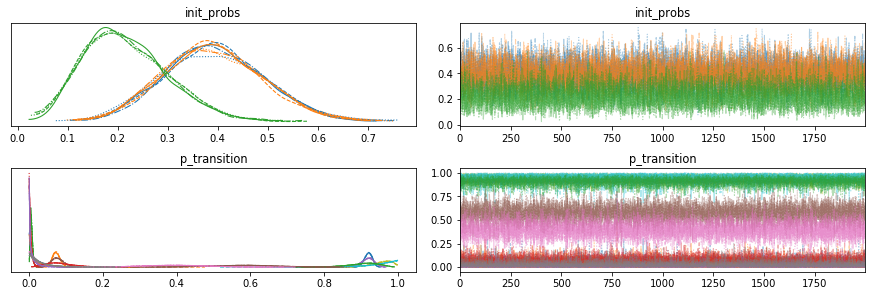

In [68]:
az.plot_trace(trace,  var_names=["init_probs", "p_transition"]);

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


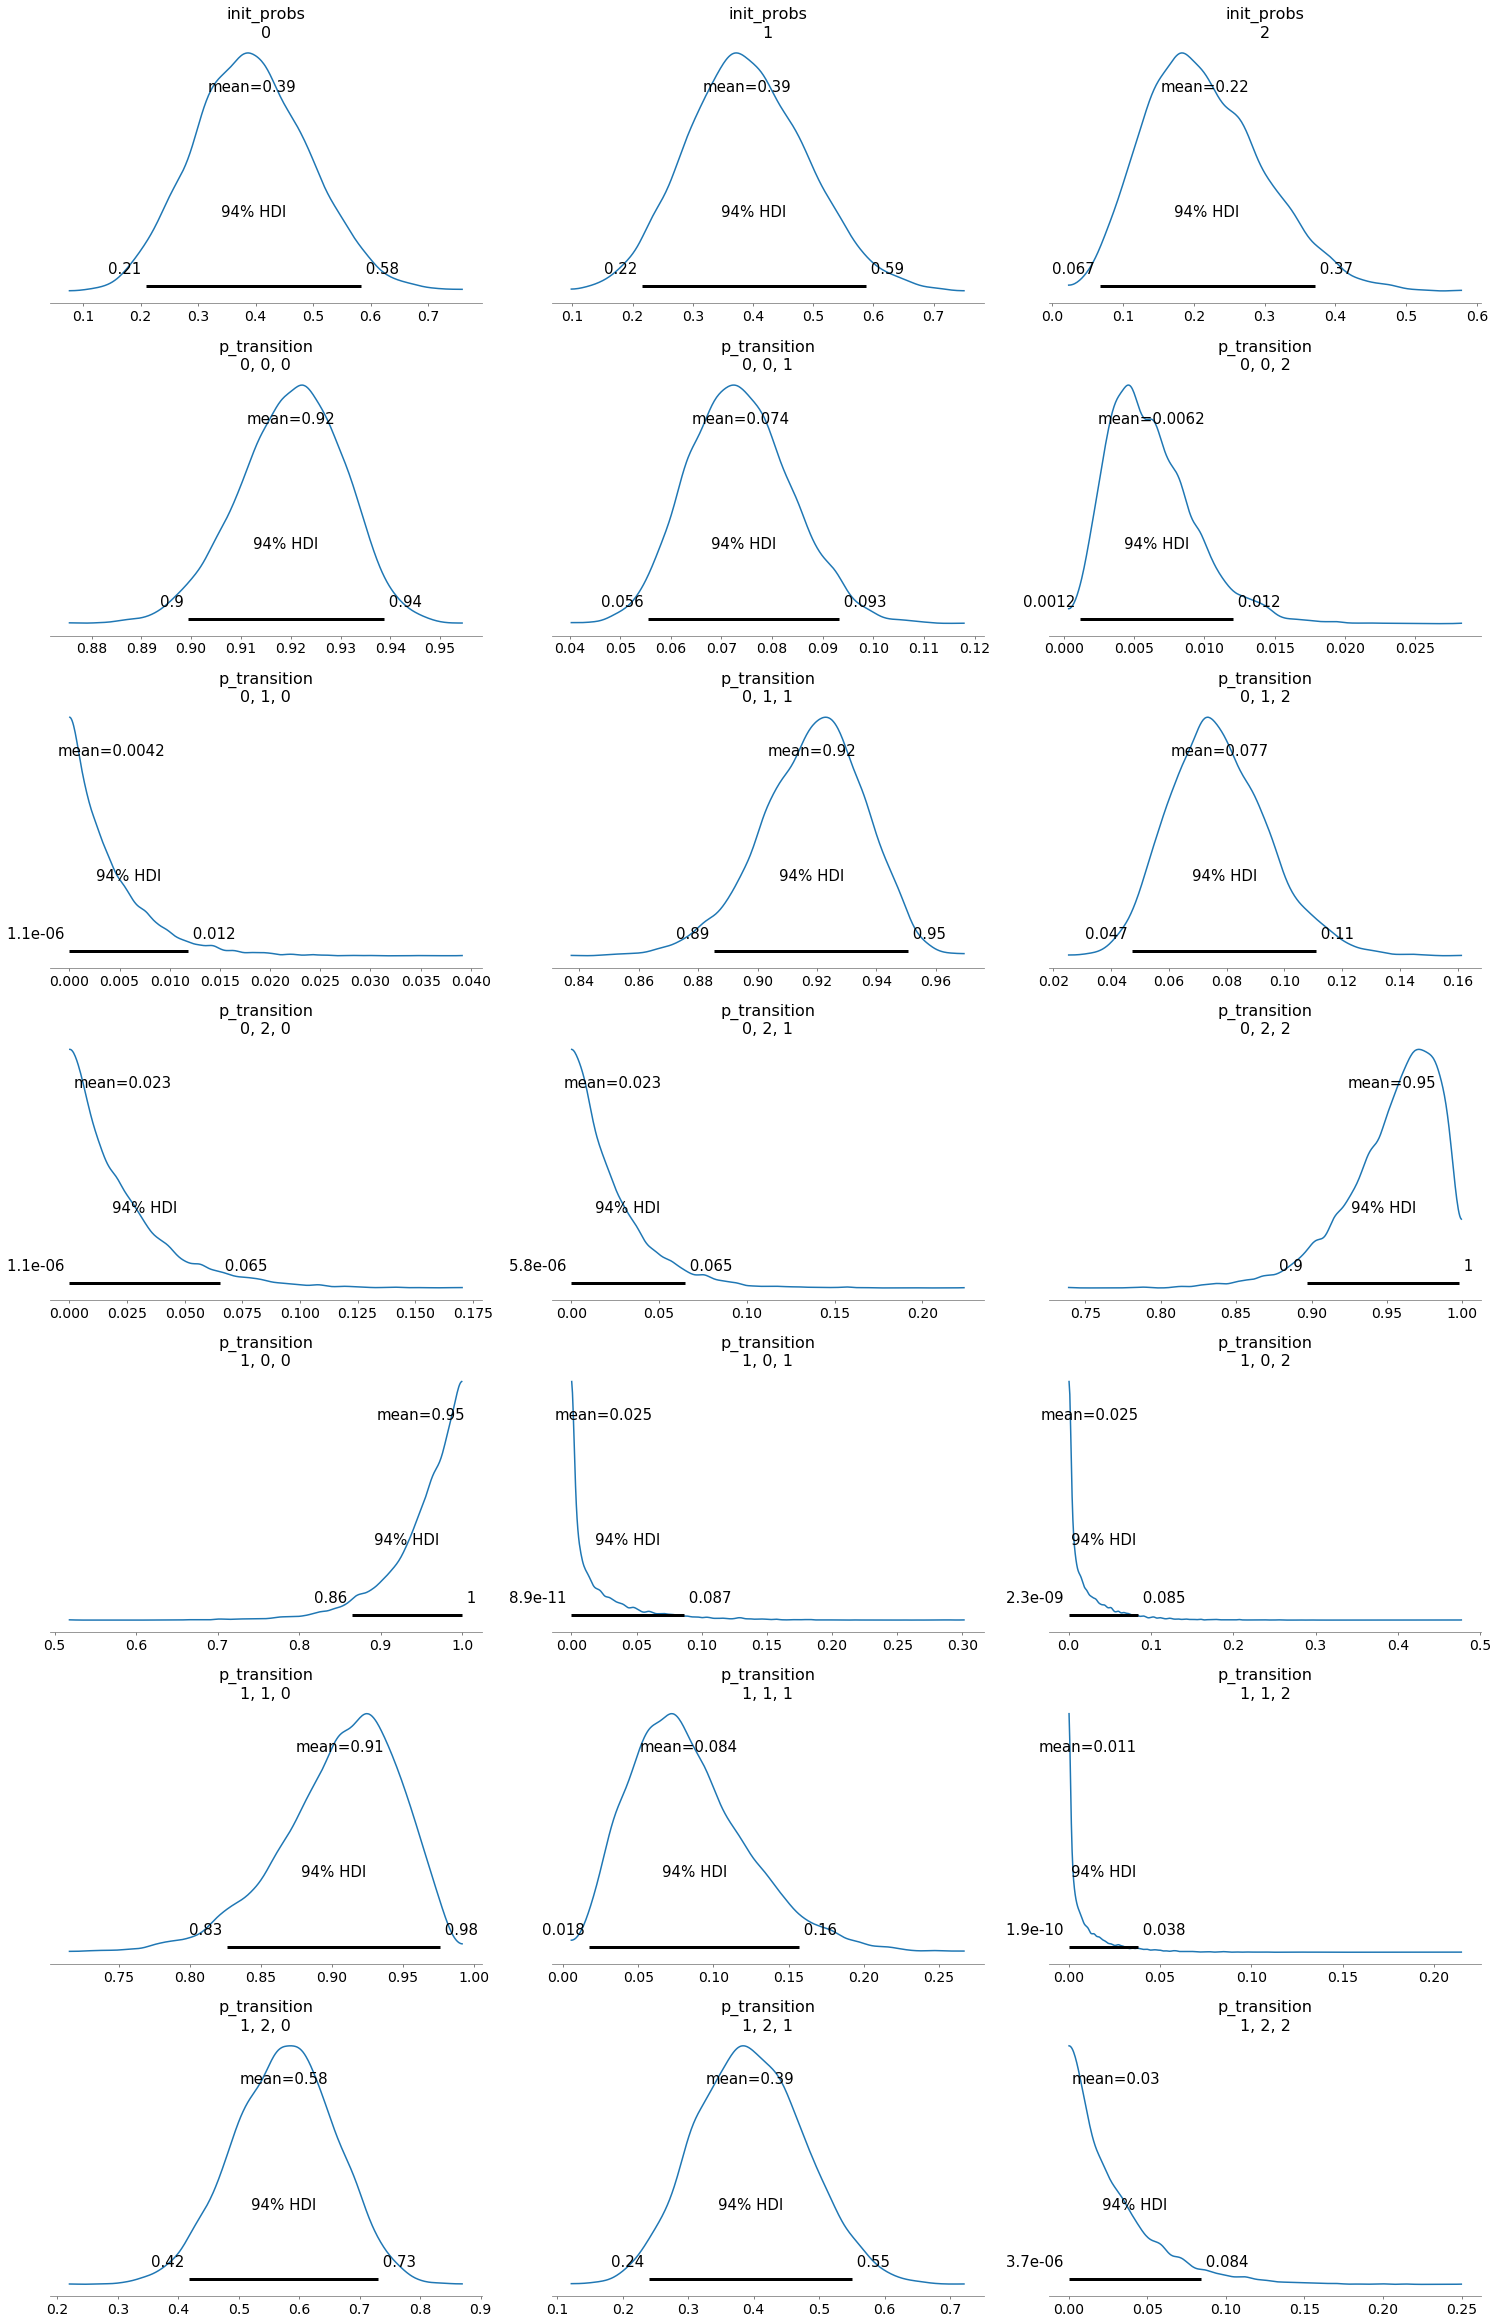

In [69]:
az.plot_posterior(trace,  var_names=["init_probs", "p_transition"]);

In [70]:
with pm.Model() as model:
    transition_mat_0 = pm.Dirichlet(
        "tr_mat_0",
        a=np.diag(np.array([5.]*n_states))+1,
        shape=(n_states, n_states))
    transition_mat_1 = pm.Dirichlet(
        "tr_mat_1",
        a=np.array([[5.,0.5, 0.5], [5.,1.,0.5], [4.,4.,1.]]),
        shape=(n_states, n_states))
    transition_mat = pm.Deterministic("p_transition", tt.stack([transition_mat_0, transition_mat_1]))
    
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones((n_states,)), shape=n_states)


    # Prior for mu, sigma and k
    μ = pm.TruncatedNormal("mu", mu=[-0.01, -0.5, -1.], sigma=0.1, upper=0., shape=(n_states,)) # different priors for the 3 Normal dist
    σ = pm.TruncatedNormal("sigma", mu=[0.1, 0.25, 0.5], sigma=0.1, lower=0., shape=(n_states,))
    k_p = pm.Beta("k", alpha=2., beta=5.) 
    
    for i in range(number_seq):
        # HMM state
        hmm_states_i = HMMStates(
            "hmm_states_" + str(i),
            p_transition=transition_mat,
            init_prob=init_probs,
            actions=actions_all_seq[i, :],
            n_states=n_states,
            shape=(lenght_seq,)
        )


        # Observed emission likelihood
        obs_i = ObservationModel(
            "emission_" + str(i),
            states=hmm_states_i,
            mu=μ,
            sigma=σ,
            k=k_p,
            actions=actions_all_seq[i, :],
            observed=np.array(emissions_all_seq[i, :]).astype("float")
        )
        
    nuts_step = pm.NUTS([model.k, model.sigma, model.mu, model.p_transition, model.init_probs], target_accept=0.95) 
    trace = pm.sample(2000, tune=1500, step=[nuts_step])

<ipython-input-70-fec086933632>:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=1500, step=[nuts_step])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [init_probs, tr_mat_0, tr_mat_1, mu, sigma, k]
>CategoricalGibbsMetropolis: [hmm_states_19, hmm_states_18, hmm_states_17, hmm_states_16, hmm_states_15, hmm_states_14, hmm_states_13, hmm_states_12, hmm_states_11, hmm_states_10, hmm_states_9, hmm_states_8, hmm_states_7, hmm_states_6, hmm_states_5, hmm_states_4, hmm_states_3, hmm_states_2, hmm_states_1, hmm_states_0]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 14503 seconds.
/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [71]:
az.summary(trace,  var_names=["init_probs", "p_transition", "mu", "sigma", "k"])

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
init_probs[0]        0.356  0.103   0.171    0.555      0.001    0.001   
init_probs[1]        0.258  0.139   0.007    0.504      0.009    0.006   
init_probs[2]        0.386  0.141   0.124    0.652      0.009    0.006   
p_transition[0,0,0]  0.933  0.011   0.913    0.954      0.001    0.000   
p_transition[0,0,1]  0.037  0.020   0.001    0.069      0.003    0.002   
p_transition[0,0,2]  0.029  0.018   0.000    0.060      0.003    0.002   
p_transition[0,1,0]  0.016  0.016   0.000    0.045      0.001    0.000   
p_transition[0,1,1]  0.904  0.071   0.778    0.997      0.009    0.006   
p_transition[0,1,2]  0.080  0.069   0.000    0.203      0.009    0.006   
p_transition[0,2,0]  0.024  0.026   0.000    0.068      0.001    0.001   
p_transition[0,2,1]  0.079  0.075   0.000    0.219      0.005    0.004   
p_transition[0,2,2]  0.897  0.081   0.752    0.999      0.006    0.005   
p_transition[1,0,0]  0.948  0.049   0.858    1.000      0.001    0.001   
p_transition[1,0,1]  0.027  0.037   0.000    0.094      0.001    0.000   
p_transition[1,0,2]  0.025  0.033   0.000    0.085      0.001    0.000   
p_transition[1,1,0]  0.902  0.066   0.786    1.000      0.003    0.002   
p_transition[1,1,1]  0.080  0.063   0.000    0.192      0.003    0.002   
p_transition[1,1,2]  0.019  0.026   0.000    0.065      0.001    0.001   
p_transition[1,2,0]  0.591  0.124   0.344    0.796      0.015    0.011   
p_transition[1,2,1]  0.374  0.120   0.164    0.603      0.015    0.011   
p_transition[1,2,2]  0.035  0.035   0.000    0.099      0.001    0.001   
mu[0]               -0.027  0.022  -0.067   -0.000      0.000    0.000   
mu[1]               -0.505  0.070  -0.636   -0.377      0.002    0.002   
mu[2]               -0.948  0.089  -1.109   -0.772      0.002    0.002   
sigma[0]             0.104  0.003   0.097    0.110      0.000    0.000   
sigma[1]             0.272  0.028   0.222    0.327      0.004    0.003   
sigma[2]             0.395  0.041   0.323    0.473      0.004    0.003   
k                    0.090  0.015   0.061    0.116      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
init_probs[0]          4873.0    5264.0   1.00  
init_probs[1]           226.0     493.0   1.02  
init_probs[2]           249.0     373.0   1.02  
p_transition[0,0,0]     414.0     982.0   1.01  
p_transition[0,0,1]      50.0     148.0   1.05  
p_transition[0,0,2]      51.0     255.0   1.05  
p_transition[0,1,0]     574.0    1211.0   1.01  
p_transition[0,1,1]      80.0      63.0   1.05  
p_transition[0,1,2]      86.0      66.0   1.04  
p_transition[0,2,0]     635.0     979.0   1.01  
p_transition[0,2,1]     203.0     531.0   1.01  
p_transition[0,2,2]     174.0     550.0   1.02  
p_transition[1,0,0]    2524.0    4935.0   1.00  
p_transition[1,0,1]    2571.0    2957.0   1.00  
p_transition[1,0,2]    3195.0    3326.0   1.00  
p_transition[1,1,0]     522.0    1534.0   1.00  
p_transition[1,1,1]     513.0    1681.0   1.00  
p_transition[1,1,2]    1317.0    2049.0   1.00  
p_transition[1,2,0]      72.0     261.0   1.04  
p_transition[1,2,1]      73.0     168.0   1.04  
p_transition[1,2,2]    1572.0    2590.0   1.00  
mu[0]                  2634.0    3371.0   1.00  
mu[1]                  1033.0    3160.0   1.01  
mu[2]                  1412.0    4185.0   1.00  
sigma[0]                309.0    1613.0   1.01  
sigma[1]                 47.0     342.0   1.05  
sigma[2]                130.0     467.0   1.02  
k                      2770.0    2974.0   1.00

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b5ae42430>,
      dtype=object)

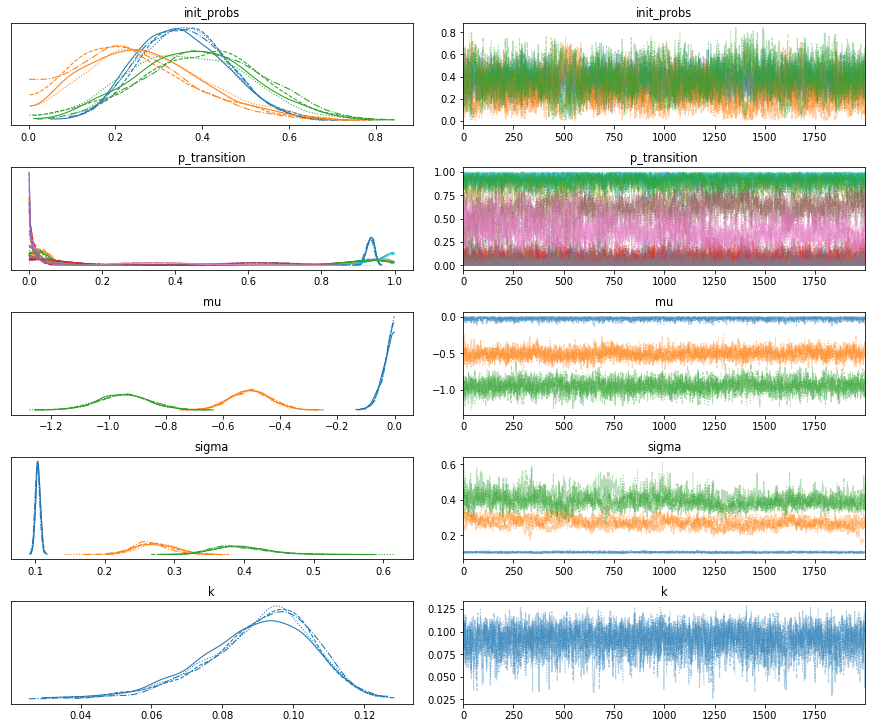

In [72]:
az.plot_trace(trace,  var_names=["init_probs", "p_transition", "mu", "sigma", "k"]);

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


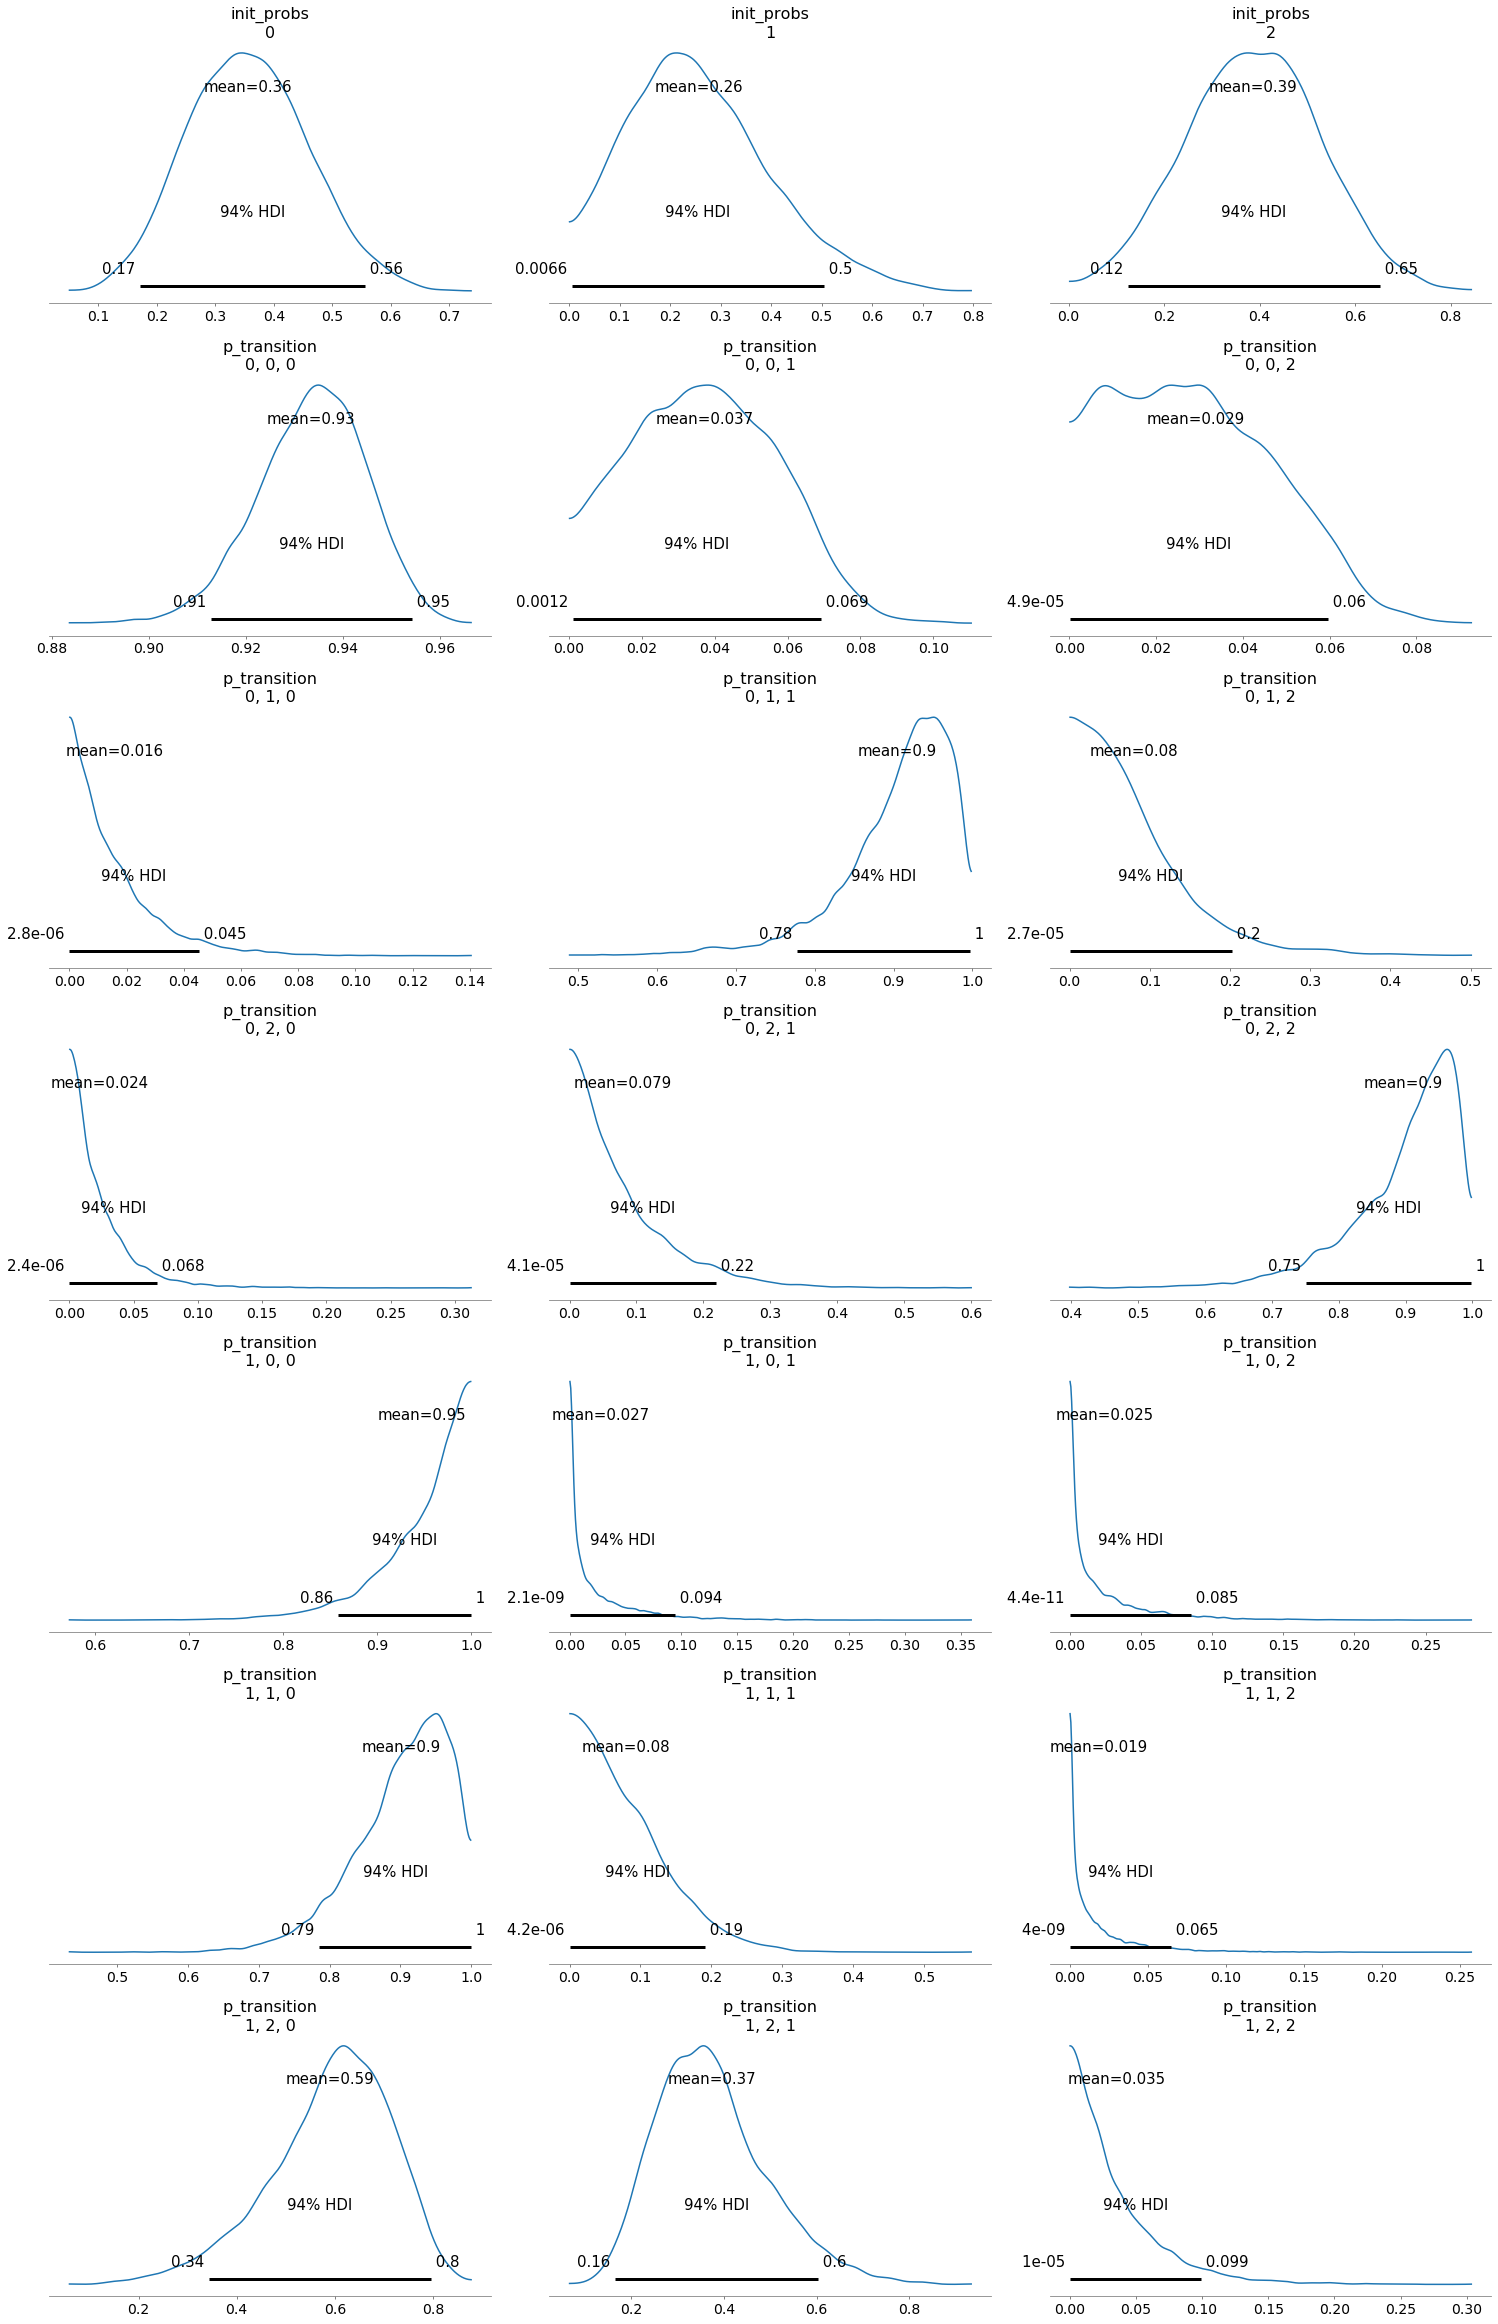

In [73]:
az.plot_posterior(trace,  var_names=["init_probs", "p_transition"]);

/home/garcieri/anaconda3/envs/hmm/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


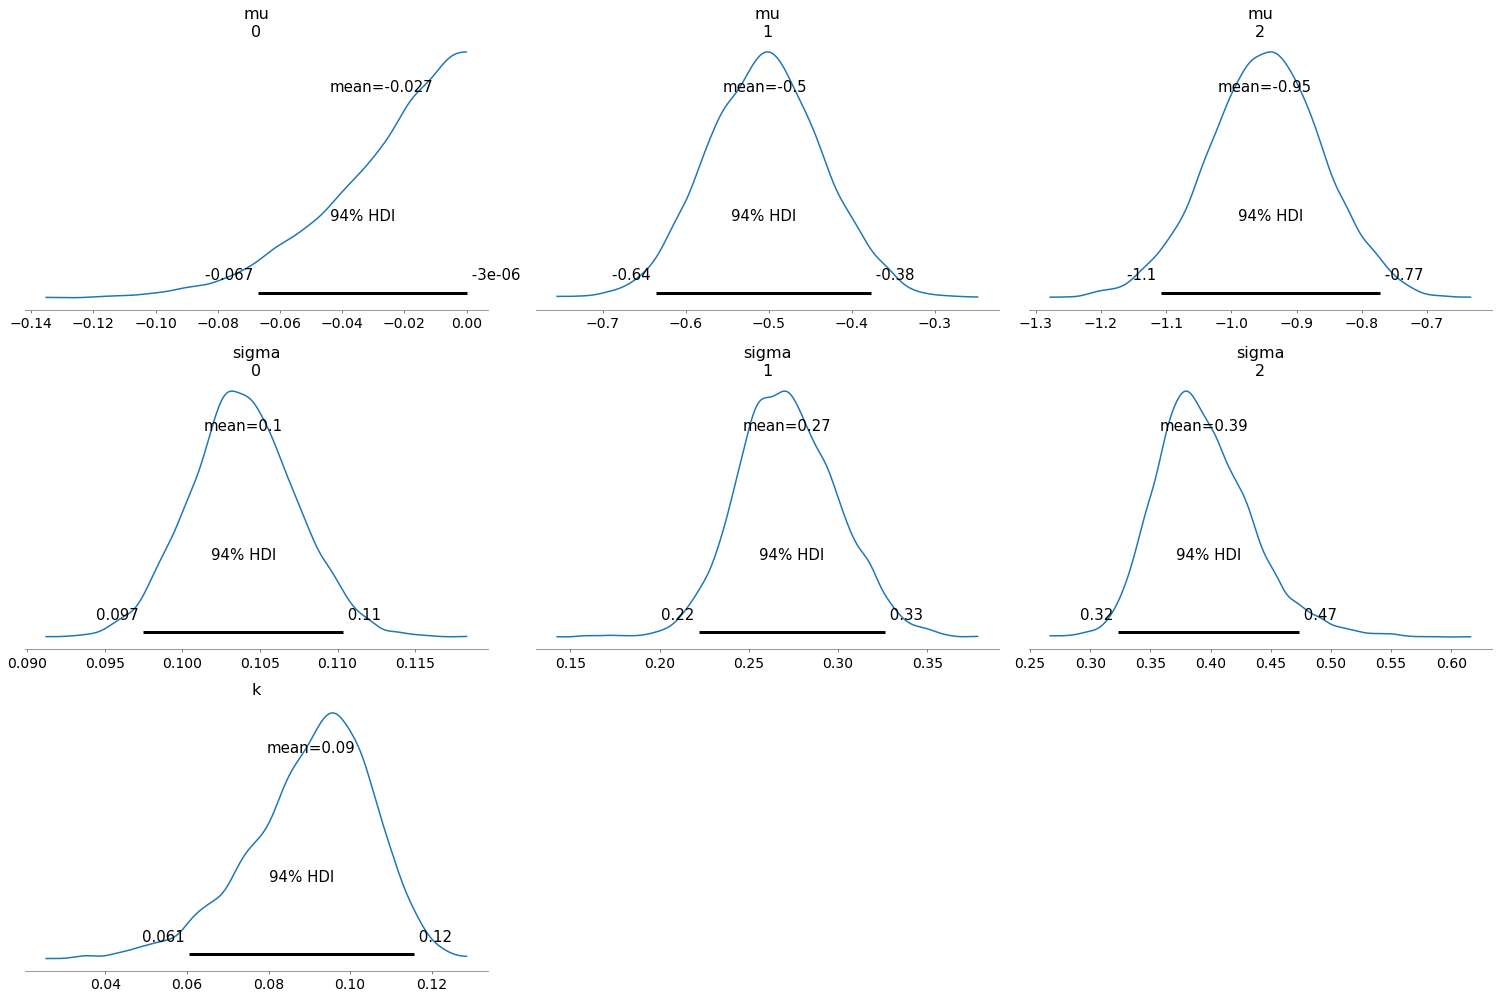

In [74]:
az.plot_posterior(trace,  var_names=["mu", "sigma", "k"]);